In [27]:


import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd


def read_rewards_from_file(file_path:str)-> tuple[dict, dict, list[str]]:
    """
    Read the rewards history file and returns a dictionary with the total reward and the individual reward for each step.
    Args:
        file_path: the path to the rewards history file.

    Returns:
        total_rewards: a dictionary that maps the step number with the total reward for that step.
        individual_rewards: a dictionary that maps the step number with the individual reward for each agent for that step.
        players_index: a list with the ids of the players.
    """
    try:
        with open(file_path, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        print("File with the rewards history not found: %s", file_path)
        return {}, {}
            
    rewards_per_step = {}

    for line in lines:
        step, rewards_str = line.strip().split(':')[0], line[line.find(':')+1:]
        rewards_dict = eval(rewards_str.strip())
        rewards_per_step[step] = rewards_dict

    players_index = rewards_per_step['1'].keys()
    
    individual_rewards = {'1': rewards_per_step['1']}
    for step in range(2, len(rewards_per_step)):
        # Suma del anterior con el actual
        individual_rewards[str(step)] = {key: individual_rewards[str(step-1)][key] + rewards_per_step[str(step)][key] for key in players_index}


    total_rewards = {'1': sum(rewards_per_step['1'].values())}
    for step in range(2, len(rewards_per_step)):
        # Suma del anterior con el actual
        total_rewards[str(step)] = sum(individual_rewards[str(step)].values())
    
    #print(total_rewards, individual_rewards, players_index)
    return total_rewards, individual_rewards, players_index

def read_trees_info_from_file(file_path:str)-> dict:
    """
    Read the trees info file and returns a dictionary with the trees info for each step.
    Args:
        file_path: the path to the trees info file.

    Returns:
        trees_info: a dictionary that maps the step number with the trees info for that step.
    """
    try:
        with open(file_path, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        #logger.error("File with the trees info not found: %s", file_path)
        print("File with the trees info not found: %s", file_path)
        return {}
    # Data is in format like 
    #1: {1: 6, 2: 13, 3: 13, 4: 6, 5: 13, 6: 13}
    trees_info = {}

    for line in lines:
        step, trees_info_str = line.strip().split(':')[0], line[line.find(':')+1:]
        trees_info_dict = eval(trees_info_str.strip())
        trees_info[step] = trees_info_dict
    # Delete last step because it is the same as the previous one
    del trees_info[str(len(trees_info))]
    
    return trees_info

def generate_video_from_images(image_folder:str, video_name:str, rewards:dict, players_index:list[str], round_map:dict, output_resolution:tuple, duration:float=0.2)->None:

    """
    Generate a video from a set of images.

    Parameters:
    - image_folder: the path to the folder containing the images.
    - video_name: the name (including path) of the video file to be created.
    - duration: the duration each image will be displayed in seconds.
    """

    # Obteniendo las imágenes de la carpeta
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]
    images.sort(key=lambda x: int(x.split('.')[0]))  # Asumiendo que el nombre del archivo es el "step" y no tiene puntos adicionales
    

    out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 1/duration, output_resolution)

    for i in range(len(images)):
        img_path = os.path.join(image_folder, images[i])
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, output_resolution, interpolation=cv2.INTER_NEAREST)  # Redimensiona la imagen a la resolución deseada

        # Añadiendo el texto a la imagen
        step = images[i].split('.')[0]
        reward = rewards.get(step, 0)
        per_capita_reward = reward / len(players_index)
        img_with_text = add_text_to_image(img_resized, round_map[str(int(step))], step, per_capita_reward)

        out.write(img_with_text)

    out.release()


def add_text_to_image (img:np.ndarray, round:str, step:str, reward_per_capita:float)->np.ndarray:
    """
    Adds text to the image.

    Args:
    - img: the image to which the text will be added.
    - round: the round number.
    - step: the step number.
    - reward_per_capita: the reward per capita for the current round.

    Returns:
    - img: the image with the text added.
    """

    height, _, _ = img.shape
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"Round: {round} - Step: {step} - Reward per capita: {reward_per_capita:,.2f}"
    cv2.putText(img, text, (12, int(height * 0.035)), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return img

def read_rounds_history(file_path:str, image_folder:str):
    """
    Reads the rounds history file and returns a dictionary that maps the step number with the round number.
    
    Args:
        file_path: the path to the rounds history file.

    Returns:
        round_map: a dictionary that maps the step number with the round number.
    """
    try:
        with open(file_path, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        #logger.warning("File with the steps history not found: %s", file_path)
        print("File with the steps history not found: %s", file_path)
        lines =  []
     
    # Obteniendo las imágenes de la carpeta
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]
    images.sort(key=lambda x: int(x.split('.')[0]))  # Asumiendo que el nombre del archivo es el "step" y no tiene puntos adicionales
    max_image_step = int(images[-1][:-4])
    
    round_map = {}
    for line in lines:
        round, step = line.strip().split(' ')
        round_map[step] = round
    max_step = len(images) - 1

    if max_image_step != max_step:
        round_map[str(max_image_step)] = str(int(round_map[str(max_step)]) + 1)
        max_step = max_image_step

    round_map['0'] = '0'
    for step in range(1, max_step+1):
        if str(step) not in round_map.keys():
            round_map[str(step)] = round_map[str(step-1)]
    return round_map

def generate_random_color():
    r = random.random()
    g = random.random()
    b = random.random()
    return (r, g, b)

def predifined_colors(index:int):
    colors = [(0.0, 0.0, 1.0),\
             (0.0, 0.5, 0.0),\
             (1.0, 0.0, 0.0),\
             (0.0, 0.75, 0.75),\
            (0.75, 0.0, 0.75),\
            (0.75, 0.75, 0.0), (0.25, 0.25, 0.25), (0.75, 0.25, 0.25), (0.95, 0.95, 0.0), (0.25, 0.25, 0.75), (0.75, 0.75, 0.75), (0.0, 1.0, 0.0), (0.76, 0.57, 0.17), (0.54, 0.63, 0.22), (0.34, 0.57, 0.92), (1.0, 0.10, 0.60), (0.88, 0.75, 0.73), (0.10, 0.49, 0.47), (0.66, 0.34, 0.65), (0.99, 0.41, 0.23)]
    return colors[index]

def generate_rewards_plot (individual_rewards:dict, round_map:dict, record_folder:str)->None:
    individual_rewards = { round_map[step]: rew for step, rew in individual_rewards.items()}

    # Uses round map to evaluate only the steps that are part of a round from individual rewards
    steps = list(individual_rewards.keys())
    steps = [int(s) for s in steps]
    num_players = len(list(individual_rewards.values())[0])
    per_capita_reward = [sum(list(val.values()))/num_players for val in individual_rewards.values()]
    individual_rewards = [np.array(list(val.values())) for val in individual_rewards.values()]

    # Transform to numpy array
    individual_rewards = np.array(individual_rewards)

     # Determine the max step value and calculate ticks for each 10% interval
    max_step = max(steps)
    step_interval = max_step // 10
    x_ticks = np.arange(0, max_step + step_interval, step_interval)

    # Graph
    plt.figure(figsize=(12, 6))
    # Vector of colors for each individual
    colors = [predifined_colors(i) for i in range(num_players)]
    for i in range(num_players):
        plt.plot(steps, individual_rewards[:, i], label=f"Individual {i + 1}", linewidth=2, linestyle="--", color=colors[i])
    plt.plot(steps, per_capita_reward, label="Per capita reward", linewidth=2.5, linestyle="-", color="orange")
    
    # Set custom ticks
    plt.xticks(x_ticks)

    plt.xlabel("Steps")
    plt.ylabel("Reward")
    plt.title("Individual reward vs Per capita average reward per step")
    plt.legend()
    plt.grid(True)
    plt.savefig(record_folder + '/rewards_plot.png')



def recreate_records(record_path:str, image_folder:str = 'world', video_name:str = 'output_video.avi', output_resolution:tuple = (1600, 1200), rounds_file:str = 'steps_history.txt', rewards_file:str = 'rewards_history.txt')->None:
    """
    Recreates the simulation from the given record folder.

    Args:
    - record_folder: the path to the record folder.
    - image_folder: the path to the folder containing the images.
    - video_name: the name (including path) of the video file to be created.
    - output_resolution: the resolution of the output video.
    """
    rounds_path = os.path.join(record_path, rounds_file)
    rewards_path = os.path.join(record_path, rewards_file)
    image_path = os.path.join(record_path, image_folder)
    video_path = os.path.join(record_path, video_name)

    total_rewards, individual_rewards, players_index = read_rewards_from_file(rewards_path)
    round_map = read_rounds_history(rounds_path, image_path)
    #generate_video_from_images(image_path, video_path, total_rewards, players_index, round_map, output_resolution, 0.2)
    generate_rewards_plot( individual_rewards, round_map, record_path)

In [28]:

def split_logs_by_agents(log_contents, agents_list):
    # Initialize a dictionary to hold the logs for each agent
    logs_dict = {agent: '' for agent in agents_list}
    
    # Initialize variables to hold the current agent and their log sections
    current_agent = None
    current_log_section = []
    
    # Split the log file into lines
    lines = log_contents.split('\n')
    
    for line in lines:
        # Check if the line denotes the start of an agent's turn
        line = line.lower()
        for agent in agents_list:
            if f"################Agent's {agent} turn################".lower() in line:
                # If we were already collecting logs for an agent, store them in the dictionary
                if current_agent is not None:
                    logs_dict[current_agent] += '\n'.join(current_log_section)
                # Start collecting logs for the new agent
                current_agent = agent
                current_log_section = []
                break
        else:
            # If the line is not the start of an agent's turn, add it to the current log section
            if current_agent is not None:
                current_log_section.append(line)
    
    # After the last line, make sure to add the remaining logs to the respective agent
    if current_agent is not None:
        logs_dict[current_agent] += '\n'.join(current_log_section)
    
    return logs_dict


In [29]:

# Function to count the attacks by and on each agent
def count_attacks(agent_logs, agents_list, attack_action_str):
    attacks_by_agent = {agent: 0 for agent in agents_list}
    for agent in agents_list:
        # Count attacks by the agent
        attacks_by_agent[agent] += agent_logs[agent].lower().count(attack_action_str)
        
    return attacks_by_agent


In [30]:
agent_map = {'agent 0': 'Juan', 'agent 1': 'Laura', 'bot_1':'bot_1', 'bot_2':'bot_2'}

agent_map = {'agent 0': 'Juan', 'agent 1': 'Laura', 'agent 2': 'Pedro'}


# Function to count the incapacitations by each agent
def count_incapacitations(agent_logs, agents_list, agent_map):
        # Initialize a dictionary to hold the count of times an agent incapacitated another agent
    incapacitations_by_agent = {agent: {other_agent: 0 for other_agent in agents_list if other_agent != agent} 
                                for agent in agents_list}
    times_being_incapacitated = {agent: {other_agent: 0 for other_agent in agents_list if other_agent != agent} 
                                for agent in agents_list}

    comilla_simple = "\'"
    comilla_doble = '"'

## Delete above, this is the real
    for agent in agents_list:
        # For each agent, look through the logs of the other agents to find mentions of being taken out
        for log_agent, log_contents in agent_logs.items():
            log_contents = log_contents.lower()
            if agent != log_agent:  # Skip if it's the same agent
                for key, name in agent_map.items():
                    if name == agent:
                        comilla_simple = "'"
                        comilla_doble = '"'
                        incapacitation_str = f"{comilla_doble}There are no observations: You were attacked by agent {agent} and currently you\'re out of the game. At 2".lower()
                        conteo = log_contents.count(incapacitation_str)
                        incapacitations_by_agent[agent][log_agent] += conteo
                        times_being_incapacitated[log_agent][agent] += conteo
    return incapacitations_by_agent, times_being_incapacitated

    for bot_name in agents_list:
        # For each agent, look through the logs of the other agents to find mentions of being taken out
        for log_agent, log_contents in agent_logs.items():
            log_contents = log_contents.lower()
            for key, name in agent_map.items():
                if name != bot_name:
                    incapacitation_str = f"\'{bot_name}\': [{comilla_doble}There are no observations: You were attacked by agent {name} and currently you\'re out of the game. At position".lower() 
                    conteo = log_contents.count(incapacitation_str)
                    incapacitations_by_agent[name][bot_name] += conteo
                    times_being_incapacitated[bot_name][name] += conteo
            
    return incapacitations_by_agent, times_being_incapacitated



In [31]:
comilla_simple = "'"
comilla_doble = '"'
f"Scene descriptions: {comilla_simple}observation{comilla_simple}: {comilla_doble}There are no observations: You were attacked by agent Juan and currently you".lower()

'scene descriptions: \'observation\': "there are no observations: you were attacked by agent juan and currently you'

In [32]:

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_interactions(agent_interactions, num_simulations, agent_colors, folder_path:str):
    """
    Visualize the average interactions between agents using a directed graph.
    
    Args:
    - agent_interactions: a dictionary that maps each agent to another dictionary of interactions with other agents.
    - num_simulations: the number of simulations that were run to calculate the average interactions.
    - agent_colors: a dictionary that maps each agent to a color for visualization. Blue for "no bio" agents and red for "selfish" agents.
    """

    # Create a directed graph
    G = nx.DiGraph()

    # Calculate the average interactions and add edges to the graph
    for agent, interactions in agent_interactions.items():
        for target, times in interactions.items():
            average = times / num_simulations
            G.add_edge(agent, target, weight=average)

    # Extract node positions using spring layout for better spacing and aesthetics
    pos = nx.spring_layout(G, k=0.5, iterations=20)

    # Node colors based on the agent_colors dictionary
    node_colors = [agent_colors.get(node, "grey") for node in G.nodes()]  # Using get method to provide a default color

    plt.figure(figsize=(10, 8))  # Set the figure size early

    # Draw the graph components
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")
    edges = nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray", width=4)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.25, font_size=14)

    plt.title("Average Attacks Between Agents", size=15)
    # Add a subtitle with the number of simulations
    #plt.suptitle(f"Pedro is selfish scenario", size=12, y=0.92)
    plt.axis('on')

    # Add legend for agent types
    no_bio_patch = mpatches.Patch(color='blue', label='Without Personality Agent')
    selfish_patch = mpatches.Patch(color='red', label='Selfish Agent')
    plt.legend(handles=[no_bio_patch, selfish_patch], loc='best')

    # Save the graph to a file before showing it
    plt.savefig(folder_path + '/interactions_graph.png')

    plt.show()  # Show the plot as the last step


In [34]:
import re

def get_costs(log_content):
    """ 
    Extracts the price and duration of the actions from the log content.
    The price is located on line [-2] and the duration on line [-1].
    Price is in the format: "2024-04-28 13:00:00 - step_1229 - INFO - __main__ - <module>:177 - LLM total cost: {price} .... : 0.0"
    Duration is in the format: "2024-04-28 13:00:00 - step_1229 - INFO - __main__ - <module>:180 - Execution time: {duration} minutes ..... : "
    
    Args:
    - log_content: the log content as a string.
    
    Returns:
    - price: the price of the action.
    - duration: the duration of the action.
    """
    
    # Split the log content into lines
    lines = log_content.split('\n')
    
    # Extract the price and duration from the last two lines
    price_line = lines[-4]
    duration_line = lines[-3]
    
    # Use regular expressions to extract the price and duration
    price_pattern = r"LLM total cost: ([\d.]+)"
    duration_pattern = r"Execution time: ([\d.]+) minutes"
    
    # Search for the patterns in the corresponding lines
    price_match = re.search(price_pattern, price_line)
    duration_match = re.search(duration_pattern, duration_line)
    
    # Extract the price and duration if matches are found
    price = float(price_match.group(1)) if price_match else None
    duration = float(duration_match.group(1)) if duration_match else None
    
    return price, duration


simulations_folder 2024-03-13--13-45-39__sim_1 cost: 0,69 duration: 14,37
simulations_folder 2024-03-13--13-35-49__sim_7 cost: 0,20 duration: 4,85
simulations_folder 2024-03-13--13-45-56__sim_5 cost: 0,30 duration: 6,44
simulations_folder 2024-03-13--13-36-03__sim_8 cost: 0,23 duration: 5,47
simulations_folder 2024-03-13--13-35-20__sim_2 cost: 0,28 duration: 6,95
simulations_folder 2024-03-13--13-45-50__sim_4 cost: 0,27 duration: 5,53
simulations_folder 2024-03-13--13-46-01__sim_6 cost: 0,21 duration: 4,47
simulations_folder 2024-03-13--13-45-46__sim_3 cost: 0,26 duration: 5,28
simulations_folder 2024-03-13--13-45-40__sim_2 cost: 0,26 duration: 5,20
Sim 0 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 3 {'Juan': 

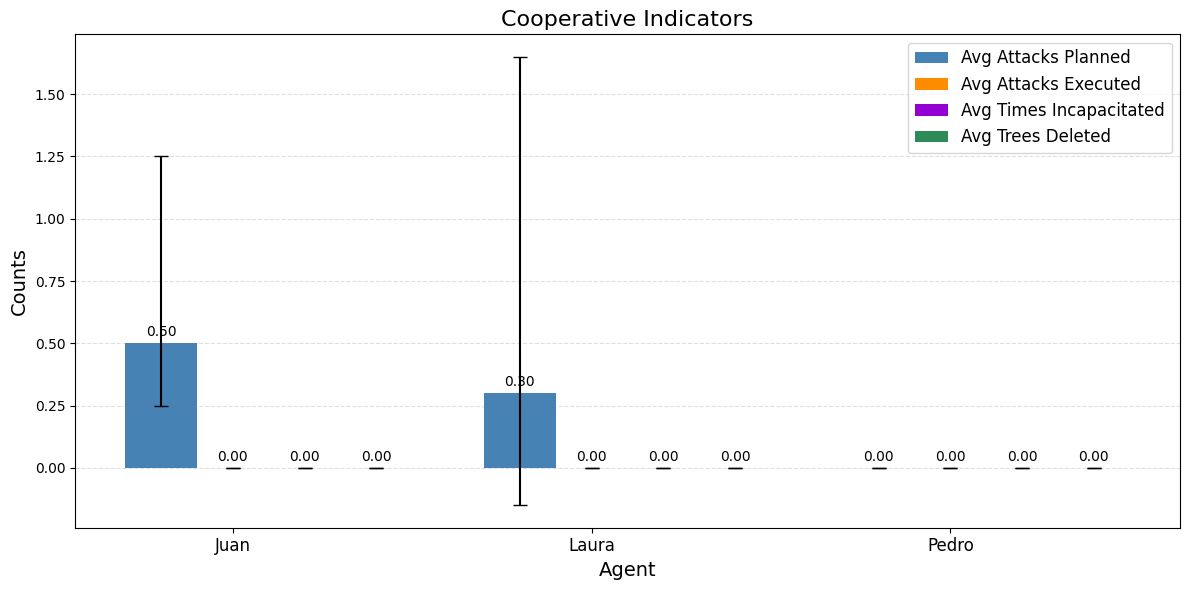

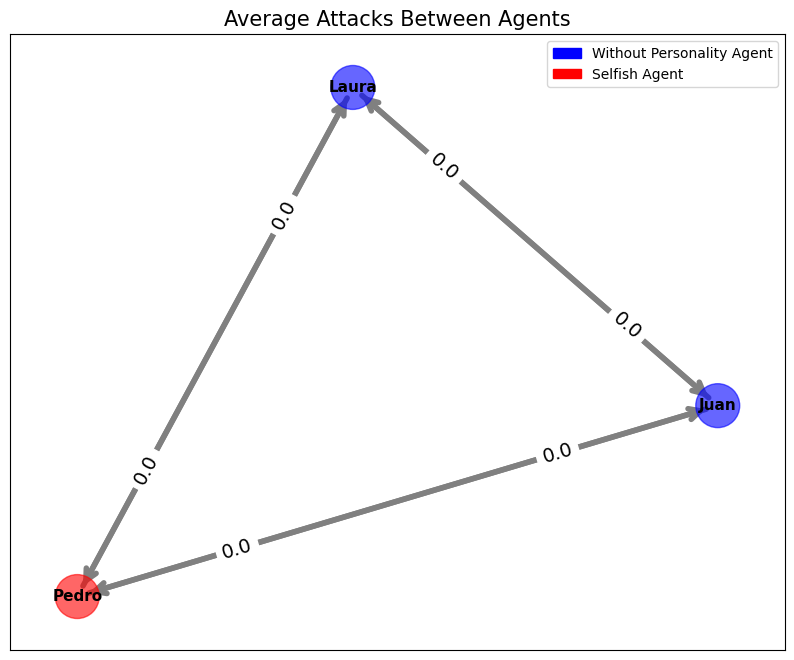

In [35]:
def generate_avg_sims_attacks_plots(simulations_folder, image_folder='world', rounds_file='steps_history.txt', rewards_file='rewards_history.txt', trees_file='trees_history.txt', show_plot=False, plot_title='Cooperative Indicators'):
    simulations_data = []
    agents_list = ['Juan', 'Laura', 'Pedro']
    #agents_list_bots = ['Juan', 'Laura', 'bot_1', 'bot_2']
    #agents_list = agents_list_bots
    # For each simulation folder in the simulations folder path
    for sim_folder in os.listdir(simulations_folder):
        # Skip if it's not a folder
        if not os.path.isdir(os.path.join(simulations_folder, sim_folder)):
            continue
        # Get the path to the simulation folder
        sim_folder_path = os.path.join(simulations_folder, sim_folder)
        # Get the path to the log file, path will be the file on the sim_folder_path folder that ends with .log
        log_file_name = [file for file in os.listdir(sim_folder_path) if file.endswith('.log')][0]
        log_file_path = os.path.join(sim_folder_path, log_file_name)
        # Read the log file
        with open(log_file_path, 'r') as file:
            log_contents = file.read()
        cost, duration = get_costs(log_contents)
        # Print with decimals separated by "," and 2 decimals
        if cost is not None:
            cost = str(f'{cost:,.2f}').replace('.', ',')
            duration = str(f'{duration:,.2f}').replace('.', ',')
            print(f'{sim_folder} cost: {cost} duration: {duration}')
        # Split the log file by agents
        agent_logs = split_logs_by_agents(log_contents, agents_list)
        # Count the attacks
        attack_action_str = '"Answer": "immobilize '.lower()
    
        attacks_by_agent = count_attacks(agent_logs, agents_list, attack_action_str)
        # Count the incapacitations
        incapacitations_by_agent, times_being_incapacitated = count_incapacitations(agent_logs, agents_list, agent_map)
    
        total_incapacitations_by_agent = {agent: sum(counts.values()) for agent, counts in incapacitations_by_agent.items()}
        total_times_being_incapacitated = {agent: sum(counts.values()) for agent, counts in times_being_incapacitated.items()}

        ## Now extract the number of trees deleted by each agent

        record_path = os.path.join(simulations_folder, sim_folder)
        rounds_path = os.path.join(record_path, rounds_file)
        rewards_path = os.path.join(record_path, rewards_file)
        image_path = os.path.join(record_path, image_folder)
        trees_path = os.path.join(record_path, trees_file)
        
        _, individual_rewards, _ = read_rewards_from_file(rewards_path)
        trees_info  = read_trees_info_from_file(trees_path) 
        alive_trees_per_step = {step: len([apples_tree for apples_tree in list(rew.values()) if apples_tree > 0]) for step, rew in trees_info.items()}
        
        ### Now for each step and each agent, we check individual rewards and if a tree was deleted, we add it to the count
        trees_deleted_by_agent_per_step = {'1':{i: 0 for i, agent in enumerate(agents_list)}}
        
        for step, rewards in individual_rewards.items():
            if step == '1':
                continue
            if step == max(individual_rewards.keys(), key=int):
                break
            trees_deleted_by_agent_per_step[step] = trees_deleted_by_agent_per_step[str(int(step)-1)].copy()
            for j, agent in enumerate(agents_list):
                if individual_rewards[str(int(step))][j] > individual_rewards[str(int(step)-1)][j]  \
                     and alive_trees_per_step[str(int(step)+1)] < alive_trees_per_step[str(int(step))]:
                    trees_deleted_by_agent_per_step[step][j] += 1
                    #print(f"{sim_folder}: Agent {agent} deleted a tree in step {step}")
        #print(trees_deleted_by_agent_per_step)
        # Uses the total for each agent to calculate the average and standard deviation
        trees_deleted_by_agent = trees_deleted_by_agent_per_step[max(trees_deleted_by_agent_per_step.keys(), key=int)]
        #print(trees_deleted_by_agent)
        # Convert the data to a dictionary
        sim_data = {
            'incapacitations_by_agent': total_incapacitations_by_agent,
            'attacks_by_agent': attacks_by_agent,
            'times_being_incapacitated': total_times_being_incapacitated,
            'trees_deleted_by_agent': trees_deleted_by_agent,
            'incapacitations_by_agent_for_graph': incapacitations_by_agent,
        }
        #print(sim_data)
        # Add the data to the list
        simulations_data.append(sim_data)

    # Convert the list of dictionaries to a dictionary of arrays for easier manipulation
    
    data_by_metric = {
        'incapacitations_by_agent': [],
        'attacks_by_agent': [],
        'times_being_incapacitated': [],
        'trees_deleted_by_agent': [],
    }
    
    incapacitations_by_agent_for_graph = {agent_base: {agent_objective:0 for agent_objective in data } for agent_base, data in simulations_data[0]['incapacitations_by_agent_for_graph'].items()}

    # Populate the new structure
    for i, sim in enumerate(simulations_data):
        data_by_metric['incapacitations_by_agent'].append(list(sim['incapacitations_by_agent'].values()))
        data_by_metric['attacks_by_agent'].append(list(sim['attacks_by_agent'].values()))
        data_by_metric['times_being_incapacitated'].append(list(sim['times_being_incapacitated'].values()))
        data_by_metric['trees_deleted_by_agent'].append(list(sim['trees_deleted_by_agent'].values()))
        #print(f'Sim {i} {sim["incapacitations_by_agent_for_graph"]}')
            
        #### EXTRACT THE INFO TO RECREATE THE GRAPH
        for agent_base in incapacitations_by_agent_for_graph:
            for agent_objective in incapacitations_by_agent_for_graph[agent_base]:
                incapacitations_by_agent_for_graph[agent_base][agent_objective] += sim['incapacitations_by_agent_for_graph'][agent_base][agent_objective]
        

    # Calculate the average and standard deviation for each metric
    averages = {metric: np.mean(data, axis=0) for metric, data in data_by_metric.items()}
    
    # Calculate separate upper and lower standard deviations
    std_devs = {metric: np.std(data, axis=0) for metric, data in data_by_metric.items()}
    upper_std_devs = {metric: std * 1.5 for metric, std in std_devs.items()}  # 50% larger than the std_dev
    lower_std_devs = {metric: std * 0.5 for metric, std in std_devs.items()}  # 50% smaller than the std_dev

    # Set up the bar plots
    agents = list(agent_map.values())
    x = np.arange(len(agents))  # the label locations
    width = 0.2  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define a color palette for visual distinction
    colors = ['steelblue', 'darkorange', 'darkviolet', 'seagreen']
    rects = [None] * len(averages)
    # yerr = np.row_stack((lower_std_devs[metric], upper_std_devs[metric]))
    # Plot each data set with error bars
    yerr2 = np.row_stack((lower_std_devs['attacks_by_agent'], upper_std_devs['attacks_by_agent']))
    rects2 = ax.bar(x - width, averages['attacks_by_agent'], width, yerr=yerr2,
                    label='Avg Attacks Planned', capsize=5, color=colors[0])

    yerr1 = np.row_stack((lower_std_devs['incapacitations_by_agent'], upper_std_devs['incapacitations_by_agent']))
    rects1 = ax.bar(x, averages['incapacitations_by_agent'], width, yerr=yerr1,
                    label='Avg Attacks Executed', capsize=5, color=colors[1])

    yerr3 = np.row_stack((lower_std_devs['times_being_incapacitated'], upper_std_devs['times_being_incapacitated']))
    rects3 = ax.bar(x + width, averages['times_being_incapacitated'], width, yerr=yerr3,
                    label='Avg Times Incapacitated', capsize=5, color=colors[2])

    yerr4 = np.row_stack((lower_std_devs['trees_deleted_by_agent'], upper_std_devs['trees_deleted_by_agent']))
    rects4 = ax.bar(x + 2*width, averages['trees_deleted_by_agent'], width, yerr= yerr4,
                    label='Avg Trees Deleted', capsize=5, color=colors[3])

    # Add text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Agent', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title(plot_title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(agents, fontsize=12)
    ax.legend(fontsize=12)

    # Adding grid for better readability
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)


    # Function to add a label on top of each bar
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Add labels to the bars
    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)
    add_labels(rects4)

    fig.tight_layout()

    # Display the plot
    plt.savefig(simulations_folder + '/attacks_plot.png')
    if show_plot:
        plt.show()
    else:
        plt.close()

    # Save the data to a csv file for further analysis, save the averages and standard deviations
    # Create a dataframe for both on the same df
    df = pd.DataFrame(averages)
    df['attacks_by_agent_std_dev'] = std_devs['attacks_by_agent']
    df['incapacitations_by_agent_std_dev'] = std_devs['incapacitations_by_agent']
    df['times_being_incapacitated_std_dev'] = std_devs['times_being_incapacitated']
    df['trees_deleted_by_agent_std_dev'] = std_devs['trees_deleted_by_agent']
    # Rounds the values to 2 decimal places
    df = df.round(2)
    # Save to a csv file
    df.to_csv(simulations_folder + '/attacks_data.csv')

    
    # Colors dictionary
    agent_colors = {'Juan': "Blue", "Laura": "Blue", "Pedro": "Red", "bot_1":"black", "bot_2":"gray"}
    
    visualize_interactions(incapacitations_by_agent_for_graph, len(simulations_data), agent_colors, simulations_folder)



simulations_folder = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/x_pedro_is_selfish_with_definition'
simulations_folder = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/11_one_tree_per_map___bots'
generate_avg_sims_attacks_plots(simulations_folder, show_plot=True)

### Functions to graph in game events per round

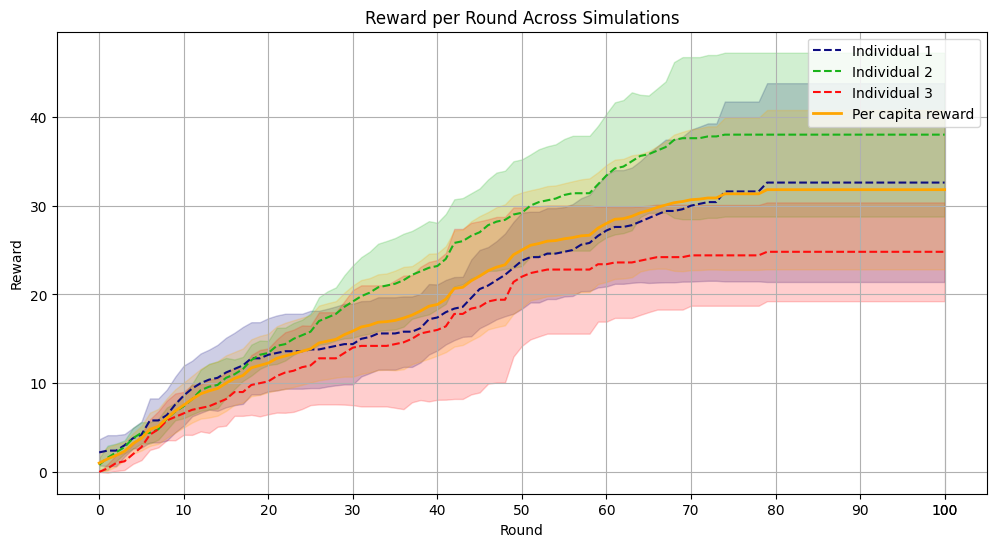

In [36]:
import os


def generate_rewards_plot(all_individual_rewards, all_rounds, record_folder, agent_kind, show_plot=False):
    num_simulations = len(all_individual_rewards)
    num_rounds = len(all_rounds)
    num_players = all_individual_rewards[0].shape[1]

    # Initialize arrays to store the sum and squared sum of rewards for each player at each step
    sum_rewards = np.zeros((num_rounds, num_players))
    sum_squared_rewards = np.zeros((num_rounds, num_players))

    # Aggregate rewards across all simulations
    for rewards in all_individual_rewards:
        #print(rewards)
        sum_rewards += rewards
        sum_squared_rewards += rewards**2

    # Calculate the mean and standard deviation for each round and each player
    mean_rewards = sum_rewards / num_simulations
    std_rewards = np.sqrt(sum_squared_rewards / num_simulations - (sum_rewards / num_simulations)**2)
    np.std(sum_squared_rewards / num_simulations - (sum_rewards / num_simulations)**2, axis=0)
    # Calculate per capita mean and standard deviation
    per_capita_mean = np.mean(mean_rewards, axis=1)
    per_capita_std = np.sqrt(np.mean(std_rewards**2, axis=1))

    # Plotting
    plt.figure(figsize=(12, 6))
    steps = all_rounds
    #colors = ['blue', 'green', 'red']  # Assuming 3 players, for more players add more colors
    # Appropiated colors for each player, assuming 3 players and colors that are not too similar and easy to distinguish on area plots
    colors = [(0.05, 0.05, 0.5),\
                (0.1, 0.7, 0.1),\
                (1.0, 0.05, 0.05),\
                (0.1, 0.1, 0.1),\
                (0.1, 0.1, 0.1),\
                (0.1, 0.1, 0.1),\
    ]
    # Plot individual rewards with standard deviation area
    for i in range(num_players):
        plt.plot(steps, mean_rewards[:, i], label=f"Individual {i+1} {agent_kind[i]}", linestyle="--", color=colors[i])
        plt.fill_between(steps, mean_rewards[:, i] - std_rewards[:, i], mean_rewards[:, i] + std_rewards[:, i], alpha=0.2, color=colors[i])

    # Plot per capita reward with standard deviation area
    plt.plot(steps, per_capita_mean, label="Per capita reward", color="orange", linewidth=2)
    plt.fill_between(steps, per_capita_mean - per_capita_std, per_capita_mean + per_capita_std, color="orange", alpha=0.2)

    plt.xlabel("Round")
    plt.ylabel("Reward")
    plt.title("Reward per Round Across Simulations")
    plt.xticks(steps[::len(steps)//10] + [max(steps)])  # X labels for each 10% of the rounds and the max step
    plt.legend()
    plt.grid(True)
    plt.savefig(record_folder + '/avg_rewards_plot.png')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    # Finally save the plotted data to a csv file for rounds, by converting data to a pandas dataframe

    columns = ['round', 'Per capita reward'] + [f'Individual {i+1} {agent_kind[i]}' for i in range(num_players)]
    df = pd.DataFrame(columns=columns)
    df['round'] = steps
    df['Per capita reward'] = per_capita_mean
    for i in range(num_players):
        df[f'Individual {i+1} {agent_kind[i]}'] = mean_rewards[:, i]

    # Round the values to 2 decimal places
    df = df.round(2)
    
    #dataframes_folder = os.path.join(record_folder, 'dataframes')
    #if not os.path.exists(dataframes_folder):
    #    os.mkdir(dataframes_folder)
    dataframes_folder = record_folder
    #Adds standard deviations to the dataframe
    df['Per capita reward std dev'] = per_capita_std
    for i in range(num_players):
        df[f'Individual {i+1} {agent_kind[i]} std dev'] = std_rewards[:, i]
    # Save to a csv file
    df.to_csv(os.path.join(dataframes_folder, 'avg_rewards_plot.csv'), index=False)


def save_all_individual_rewards_round_by_round(all_individual_rewards, simulations_folder):
    # Calculate the instance rewards
    # We prepend the initial rewards (zeros) to the diff along axis 1 (rounds axis) to maintain the shape
    instance_rewards = np.diff(all_individual_rewards, axis=1, prepend=0)
    
    # Initialize a list to hold the data for DataFrame creation
    data = []
    
    # Create a multi-index for the columns
    columns = []
    
    # Iterate through each simulation and player to populate the data list and columns multi-index
    for sim_num in range(all_individual_rewards.shape[0]):  # For each simulation
        for agent_num in range(all_individual_rewards.shape[2]):  # For each agent
            data.append(instance_rewards[sim_num, :, agent_num])
            columns.append(f'reward_agent{agent_num+1}_sim{sim_num+1}')
    
    # Convert data to a 2D array, transpose it, and create a DataFrame
    df = pd.DataFrame(np.array(data).T, columns=columns)
    
    # Create the rounds column and set it as the index
    df.index.name = 'round'
    
    # Save the DataFrame to a CSV file
    filepath = f'{simulations_folder}/individual_rewards_round_by_round.csv'
    df.to_csv(filepath)
    
    return df  # Optionally return the DataFrame for further processing or inspection

def recreate_rewards_records(simulations_folder, image_folder='world', rounds_file='steps_history.txt', rewards_file='rewards_history.txt', agents_kind=['', '', ''], show_plot=False, trees_path='trees_history.txt'):
    simulations_data = []
    all_individual_rewards = []
    all_rounds = set()
    min_slicer = 100
    max_slicer = 0
    # For each simulation folder in the simulations folder path
    for sim_folder in os.listdir(simulations_folder):
        # skip if it is not a folder
        if not os.path.isdir(os.path.join(simulations_folder, sim_folder)):
            continue
        record_path = os.path.join(simulations_folder, sim_folder)

        rounds_path = os.path.join(record_path, rounds_file)
        rewards_path = os.path.join(record_path, rewards_file)
        image_path = os.path.join(record_path, image_folder)
        trees_path = os.path.join(record_path, trees_path)

        # Assuming these functions read the files and return the appropriate data structures
        _, individual_rewards, _ = read_rewards_from_file(rewards_path)
        #print(individual_rewards)
        round_map = read_rounds_history(rounds_path, image_path)

        simulations_data.append({
            'individual_rewards': individual_rewards,
            'round_map': round_map,
        })
        
        # Normalize rewards by round and store
        normalized_rewards = {round_map[step]: rew for step, rew in individual_rewards.items()}
    
        # Uses round map to evaluate only the steps that are part of a round from individual rewards
        steps = list(normalized_rewards.keys())
        steps = [int(s) for s in steps]
        num_players = len(list(normalized_rewards.values())[0])
        per_capita_reward = [sum(list(val.values()))/num_players for val in normalized_rewards.values()]
        individual_rewards = [np.array(list(val.values())) for val in normalized_rewards.values()]
        individual_rewards = np.array(individual_rewards)

        # Trees info
        trees_info  = read_trees_info_from_file(trees_path) 
        alive_trees_per_step = {step: len([apples_tree for apples_tree in list(rew.values()) if apples_tree > 0]) for step, rew in trees_info.items()}
        
        all_individual_rewards.append(individual_rewards)
        all_rounds.update(normalized_rewards.keys())
        max_slicer = max(min_slicer, len(individual_rewards))
        


    
    # Sort all rounds to ensure consistency in plotting
    # Since there are some simulations which have less rounds than others, we will slice the rewards to the minimum number of rounds
    
    all_rounds = sorted([int(v) for v in list(all_rounds)])
    all_rounds = list(range(0, max_slicer+1))
    #print(all_rounds)
    #print(all_individual_rewards)
    
    # For each reward list on all_individual_rewards, we will re shape the lists to the max_slicer, to do that the lists with less rounds will replicate the last value, replicates will be done vertically
    all_individual_rewards =  [np.pad(rewards, ((0, max_slicer +1 - rewards.shape[0]), (0, 0)), mode='edge') for rewards in all_individual_rewards]
    
    save_all_individual_rewards_round_by_round(np.array(all_individual_rewards), simulations_folder)
    
    #all_individual_rewards = [rewards[:min_slicer, :] for rewards in all_individual_rewards]
    #print(all_individual_rewards)
    generate_rewards_plot(all_individual_rewards, all_rounds, simulations_folder, agents_kind, show_plot)


# TEST 
no_bio_path = '/home/jeyseb/MP/CooperativeGPT/logs/sim_4___resilience_with_prev_act_65p/'
recreate_rewards_records(no_bio_path, agents_kind=['', '', ''], show_plot=True)

## Plot the availability of apples and trees

In [37]:

def recreate_trees_records(simulations_folder, image_folder='world', rounds_file='steps_history.txt', trees_file='trees_history.txt', rewards_file='rewards_history.txt', trees_path='trees_history.txt', agents_kind=['', '', ''], show_plot=False):
    simulations_data = []
    all_trees_apples = []
    all_alive_trees = []
    all_rounds = set()
    min_slicer = 100
    # For each simulation folder in the simulations folder path
    for sim_folder in os.listdir(simulations_folder):
        # skip if it is not a folder
        if not os.path.isdir(os.path.join(simulations_folder, sim_folder)):
            continue
        record_path = os.path.join(simulations_folder, sim_folder)

        rounds_path = os.path.join(record_path, rounds_file)
        trees_path = os.path.join(record_path, trees_file)
        image_path = os.path.join(record_path, image_folder)
        rewards_path = os.path.join(record_path, rewards_file)

        trees_info  = read_trees_info_from_file(trees_path) 
        #print(sim_folder)
        #print (trees_info)
        round_map = read_rounds_history(rounds_path, image_path)
        apples_per_step = {step: sum(list(rew.values())) for step, rew in trees_info.items()}
        alive_trees_per_step = {step: len([apples_tree for apples_tree in list(rew.values()) if apples_tree > 0]) for step, rew in trees_info.items()}


        apples_per_step = {round_map[step]: sum(list(aps.values())) for step, aps in trees_info.items()}
        alive_trees_per_step = {round_map[step]: len([apples_tree for apples_tree in list(rew.values()) if apples_tree > 0]) for step, rew in trees_info.items()}

        # Uses round map to evaluate only the steps that are part of a round from individual rewards
        steps = list(apples_per_step.keys())
        steps = [int(s) for s in steps]

        all_rounds.update(apples_per_step.keys())
        apples_per_step = list(apples_per_step.values())
        alive_trees_per_step = list(alive_trees_per_step.values())
        all_trees_apples.append(apples_per_step)
        all_alive_trees.append(alive_trees_per_step)
        min_slicer = min(min_slicer, len(apples_per_step))

    # Sort all rounds to ensure consistency in plotting
    #all_rounds = sorted([int(v) for v in list(all_rounds)])[:min_slicer]
    #all_trees_apples = [tree[0:min_slicer] for tree in all_trees_apples]
    #all_alive_trees = [tree[0:min_slicer] for tree in all_alive_trees]
    
    # Dont use the min slicer, use the whole data and fill with 0 the missing values, transform data to matrix and fill with 0
    all_rounds = sorted([int(v) for v in list(all_rounds)])
    all_trees_apples = [tree for tree in all_trees_apples]
    all_alive_trees = [tree for tree in all_alive_trees]
    all_trees_apples = [tree + [0]*(len(all_rounds) - len(tree)) for tree in all_trees_apples]
    all_alive_trees = [tree + [0]*(len(all_rounds) - len(tree)) for tree in all_alive_trees]
    all_trees_apples = np.array(all_trees_apples)
    all_alive_trees = np.array(all_alive_trees)
    

    

    avg_trees_apples =  np.nanmean(all_trees_apples, axis=0)
    std_trees_apples = np.nanstd(all_trees_apples, axis=0)
 
    avg_alive_trees = np.nanmean(all_alive_trees, axis=0)
    std_alive_trees = np.nanstd(all_alive_trees, axis=0)

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # Plot for the average total apples thrown
    axs[0].plot(all_rounds, avg_trees_apples, label='Average Apples Thrown', color='brown')
    axs[0].fill_between(all_rounds, avg_trees_apples - std_trees_apples, avg_trees_apples + std_trees_apples, color='brown', alpha=0.2)
    axs[0].set_xlabel('Round')
    axs[0].set_ylabel('Average Total Apples')
    axs[0].set_title('Average Total Apples Thrown per Round')
    axs[0].grid(True)
    axs[0].legend()

    # Plot for the average number of alive trees
    axs[1].plot(all_rounds, avg_alive_trees, label='Average Alive Trees', color='green')
    axs[1].fill_between(all_rounds, avg_alive_trees - std_alive_trees, avg_alive_trees + std_alive_trees, color='green', alpha=0.2)
    axs[1].set_xlabel('Round')
    axs[1].set_ylabel('Average Number of Alive Trees')
    axs[1].set_title('Average Number of Alive Trees per Round')
    axs[1].grid(True)
    axs[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure to the simulations_folder (or any desired path)
    plt.savefig(os.path.join(simulations_folder, 'trees_and_apples_plot.png'))
    
    if show_plot:
        plt.show()
    else:
        plt.close()

    # Finally save the plotted data to a csv file 
    # (this will be used to generate the final plots for the report)
    # Create a dataframe with the data
    df = pd.DataFrame({'round': all_rounds, 'avg_trees_apples': avg_trees_apples, 'std_trees_apples': std_trees_apples,
                       'avg_alive_trees': avg_alive_trees, 'std_alive_trees': std_alive_trees})
    # Rounds the values to 2 decimal places
    df = df.round(2)
    
    #dataframes_folder = os.path.join(simulations_folder, 'dataframes')
    #if not os.path.exists(dataframes_folder):
    #    os.mkdir(dataframes_folder)
    # Save the dataframe to a csv file
    dataframes_folder = simulations_folder
    df.to_csv(os.path.join(dataframes_folder, 'trees_and_apples_plot.csv'), index=False)
    
    
#Try function 
#no_bio_path = '/home/jeyseb/MP/CooperativeGPT/logs/0_commons_harvest_simulations/sim_0___no_bio/'
#resilience_path = '/home/jeyseb/MP/CooperativeGPT/logs/sim_0___resilience/'
#recreate_trees_records(resilience_path, show_plot=True)


In [38]:
import cv2
import numpy as np

def create_one_dashboard_image(simulation_folder, show_plot=False):
    # Read the images
    attacks_plot = cv2.imread(simulation_folder + '/attacks_plot.png')
    avg_rewards_plot = cv2.imread(simulation_folder + '/avg_rewards_plot.png')
    trees_and_apples_plot = cv2.imread(simulation_folder + '/trees_and_apples_plot.png')

    # Get the dimensions of the images
    attacks_height, attacks_width = attacks_plot.shape[:2]
    avg_rewards_height, avg_rewards_width = avg_rewards_plot.shape[:2]
    trees_and_apples_height, trees_and_apples_width = trees_and_apples_plot.shape[:2]

    # Calculate the total height for the first two images (one above the other)
    total_height = attacks_height + avg_rewards_height
    
    # Calculate the maximum width among the three images
    max_width = max(attacks_width, avg_rewards_width, trees_and_apples_width)

    # Create a new image with the calculated dimensions
    # The width is the sum of max width of the first two images and the width of the third image
    # The height is the total height of the first two images
    dashboard_image = np.zeros((total_height, max_width + trees_and_apples_width, 3), dtype=np.uint8)

    # Place the first two images one above the other on the left
    #dashboard_image[:attacks_height, :attacks_width] = attacks_plot
    #dashboard_image[attacks_height:total_height, :avg_rewards_width] = avg_rewards_plot

    dashboard_image[:avg_rewards_height, :avg_rewards_width] = avg_rewards_plot
    dashboard_image[avg_rewards_height:total_height, :attacks_width] = attacks_plot
    
    # Resize the third image to match the total height of the first two images, if necessary
    if trees_and_apples_height != total_height:
        trees_and_apples_plot = cv2.resize(trees_and_apples_plot, (trees_and_apples_width, total_height))

    # Place the third image to the right of the first two images
    dashboard_image[:, max_width:max_width + trees_and_apples_width] = trees_and_apples_plot

    # Save the image
    cv2.imwrite(simulation_folder + '/dashboard_image.png', dashboard_image)

    # Show the image
    #cv2.imshow('Dashboard Image', dashboard_image)
    # Plot the image with matplotlib
    #Change the color order from BGR to RGB
    dashboard_image = cv2.cvtColor(dashboard_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.imshow(dashboard_image)
    plt.axis('off')
    if show_plot:
        plt.show()
    else:
        plt.close()

# Try function
#no_bio_path = '/home/jeyseb/MP/CooperativeGPT/logs/0_commons_harvest_simulations/sim_0___no_bio/'
#create_one_dashboard_image(no_bio_path)


## Plot the indicators about attacks and moves to the last apple

In [39]:
import json 
def calculate_custom_indicators(simulations_folder):
    indicators_filename = 'custom_indicators.json'
    # Read the indicators from the simulations
    indicators = []
    for sim_folder in os.listdir(simulations_folder):
        # skip if it is not a folder
        if not os.path.isdir(os.path.join(simulations_folder, sim_folder)):
            continue
        indicators_per_sim = os.path.join(simulations_folder, sim_folder, indicators_filename)
        with open(indicators_per_sim, 'r') as file:
            indicators_per_sim = json.load(file)
        indicators.append(indicators_per_sim)

    # Create a dataframe with the indicators
    df = pd.DataFrame({'agent': [agent for indicator_file in indicators for indicator in indicator_file.keys() for agent in indicator_file[indicator].keys()]})
    df['indicator'] = [indicator for indicator_file in indicators for indicator in indicator_file.keys() for value in indicator_file[indicator].values()]
    df['sim'] = [sim_id+1 for sim_id, indicator_file in enumerate(indicators) for indicator in indicator_file.keys() for value in indicator_file[indicator].values()]
    df['value'] = [value for indicator_file in indicators for indicator in indicator_file.keys() for value in indicator_file[indicator].values()]

    # Calculate the average and standard deviation of the indicators for each agent
    df_by_agent = df.groupby(['agent', 'indicator']).agg({'value': ['mean', 'std']}).reset_index()
    # Sort the dataframe by the indicator and the mean value
    df_by_agent.sort_values(by=['indicator', ('value', 'mean')], inplace=True, ascending=False)

    # Calculate the average and standard deviation of the indicators for the population
    df_by_indicator = df.groupby(['indicator']).agg({'value': ['mean', 'std']}).reset_index()

    ############################## first plot      
    # Plot the average of the portion of times the agents moved towards the last apple
    df_moves = df_by_agent.loc[df_by_agent['indicator'] == 'portion_move_towards_last_apple']
    df_moves_population = df_by_indicator.loc[df_by_indicator['indicator'] == 'portion_move_towards_last_apple']
    std_moves = np.row_stack((np.minimum(df_moves[('value', 'std')], df_moves[('value', 'mean')]), df_moves[('value', 'std')]))
    plt.bar(df_moves['agent'], df_moves[('value', 'mean')], yerr=std_moves, capsize=5)
    std_moves_population = np.row_stack((np.minimum(df_moves_population[('value', 'std')], df_moves_population[('value', 'mean')]), df_moves_population[('value', 'std')]))
    plt.bar('Population', df_by_indicator.loc[df_by_indicator['indicator'] == 'portion_move_towards_last_apple', ('value', 'mean')], yerr=std_moves_population, capsize=5)
    plt.title('Average of the portion of times the agents moved towards the last apple')
    plt.savefig(os.path.join(simulations_folder, 'move_towards_last_apple_indicator.jpg'))
    plt.show()

    ############################## second plot
    # Plot the avarage of times the agents took the last apple
    df_last_apple = df_by_agent.loc[df_by_agent['indicator'] == 'times_took_last_apple']
    df_last_apple_population = df_by_indicator.loc[df_by_indicator['indicator'] == 'times_took_last_apple']
    std_last_apple = np.row_stack((np.minimum(df_last_apple[('value', 'std')], df_last_apple[('value', 'mean')]), df_last_apple[('value', 'std')]))
    plt.bar(df_last_apple['agent'], df_last_apple[('value', 'mean')], yerr=std_last_apple, capsize=5)
    std_last_apple_population =  np.row_stack((np.minimum(df_last_apple_population[('value', 'std')], df_last_apple_population[('value', 'mean')]), df_last_apple_population[('value', 'std')]))
    plt.bar('Population', df_last_apple_population[('value', 'mean')], yerr=std_last_apple_population, capsize=5)
    plt.title('Average of times the agents took the last apple')
    plt.savefig(os.path.join(simulations_folder, 'took_last_apple_indicator.jpg'))
    plt.show()

    ############################## third plot
    # Plot the average of attacks per agent
    # Filter data for 'times_decide_to_attack' and 'effective_attack' indicators
    df_attacks_plot = df_by_agent.loc[df_by_agent['indicator'] == 'times_decide_to_attack', ['agent', 'value']].reset_index(drop=True)
    df_eff_attacks_plot = df_by_agent.loc[df_by_agent['indicator'] == 'effective_attack', ['agent', 'value']].reset_index(drop=True)

    df_attacks_plot.loc[len(df_attacks_plot.index)] = ['Population', *df_by_indicator.loc[df_by_indicator['indicator'] == 'times_decide_to_attack', [('value', 'mean'), ('value', 'std')]].values[0]]
    df_eff_attacks_plot.loc[len(df_eff_attacks_plot.index)] = ['Population', *df_by_indicator.loc[df_by_indicator['indicator'] == 'effective_attack', [('value', 'mean'), ('value', 'std')]].values[0]]

    # Calculate the lower bound for error bars
    std_attacks = np.row_stack((np.minimum(df_attacks_plot[('value', 'std')], df_attacks_plot[('value', 'mean')]), df_attacks_plot[('value', 'std')]))
    std_eff_attacks = np.row_stack((np.minimum(df_eff_attacks_plot[('value', 'std')], df_attacks_plot[('value', 'mean')]), df_eff_attacks_plot[('value', 'std')]))

    # Define width of each bar
    bar_width = 0.35

    # Create x positions for each agent
    x = np.arange(len(df_attacks_plot['agent']))

    # Plot bars for 'times_decide_to_attack' and 'effective_attack' indicators
    plt.bar(x - bar_width/2, df_attacks_plot[('value', 'mean')], yerr=std_attacks, capsize=5, width=bar_width, label='Attacks')
    plt.bar(x + bar_width/2, df_eff_attacks_plot[('value', 'mean')], yerr=std_eff_attacks, capsize=5, width=bar_width, label='Eff. Attacks')

    # Assign agent labels to x ticks
    plt.xticks(x, df_attacks_plot['agent'])

    # Display legend and title
    plt.legend()
    plt.title('Average of attacks per agent')

    # Show plot
    plt.savefig(os.path.join(simulations_folder, 'attacks_indicator.jpg'))
    plt.show()

    ################# Save the data to a csv file for further analysis
    df.pivot(index=['indicator', 'agent'], columns='sim', values='value').to_csv(os.path.join(simulations_folder, 'indicators.csv'))
    df_by_indicator['agent'] = 'Population'
    pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\
        sort_values(by=['indicator', ('value', 'mean')], ascending=False).reset_index(drop=True).to_csv(os.path.join(simulations_folder, 'indicators_summary.csv'))

## Plot a graph by using attacks

# OFFICIAL EXPERIMENTS

### 0. No Bio

In [40]:
resilienece_path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/0_no_bio'

#recreate_rewards_records(resilienece_path)
#recreate_trees_records(resilienece_path)
#generate_avg_sims_attacks_plots(resilienece_path)

#create_one_dashboard_image(resilienece_path, show_plot=True)

### 1. All Coop

In [41]:
resilienece_path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/1_all_coop'

#recreate_rewards_records(resilienece_path)
#recreate_trees_records(resilienece_path)
#generate_avg_sims_attacks_plots(resilienece_path)

#create_one_dashboard_image(resilienece_path, show_plot=True)

### All Coop With Definition

simulations_folder 2024-03-04--18-47-21__sim_7 cost: 21,68 duration: 274,88
simulations_folder 2024-03-04--18-47-49__sim_10 cost: 20,02 duration: 263,30
simulations_folder 2024-03-11--16-22-55__sim_2 cost: 7,58 duration: 105,78
simulations_folder 2024-03-04--18-47-09__sim_5 cost: 12,99 duration: 169,89
simulations_folder 2024-03-04--18-46-55__sim_3 cost: 15,43 duration: 240,17
simulations_folder 2024-03-04--18-47-43__sim_9 cost: 11,46 duration: 143,61
simulations_folder 2024-03-11--16-22-53__sim_1 cost: 10,50 duration: 175,18
simulations_folder 2024-03-11--16-23-00__sim_3 cost: 10,13 duration: 165,77
simulations_folder 2024-03-04--18-47-37__sim_8 cost: 24,97 duration: 309,09
simulations_folder 2024-03-04--18-47-15__sim_6 cost: 21,54 duration: 278,36
Sim 0 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura

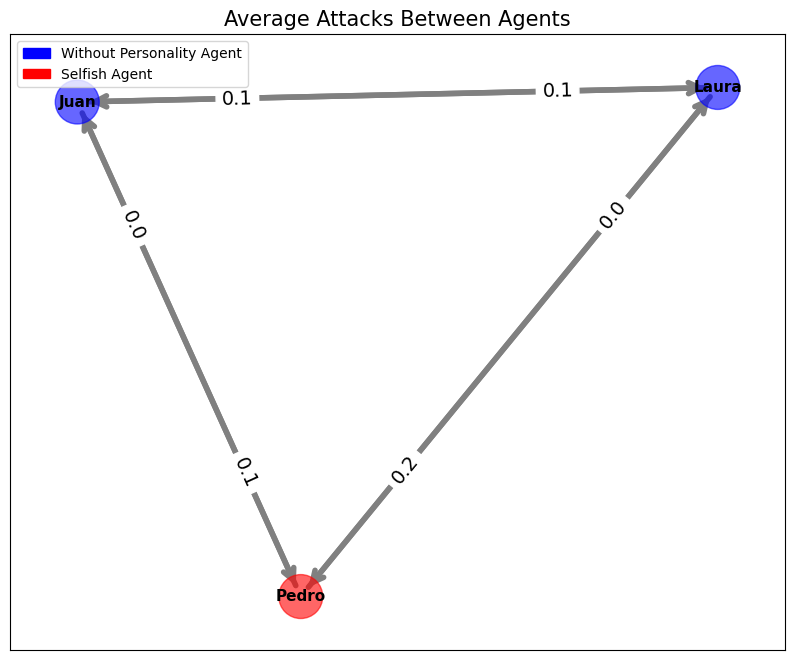

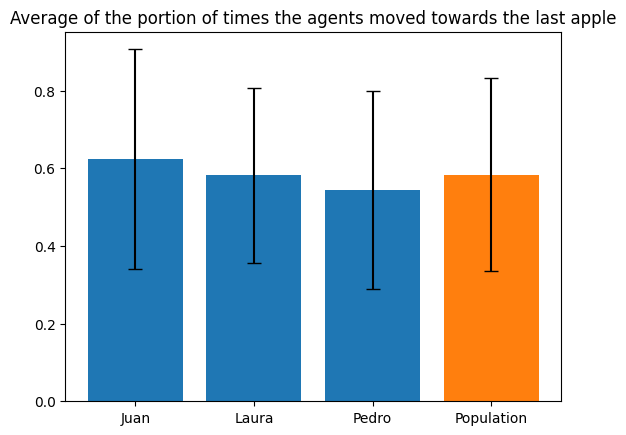

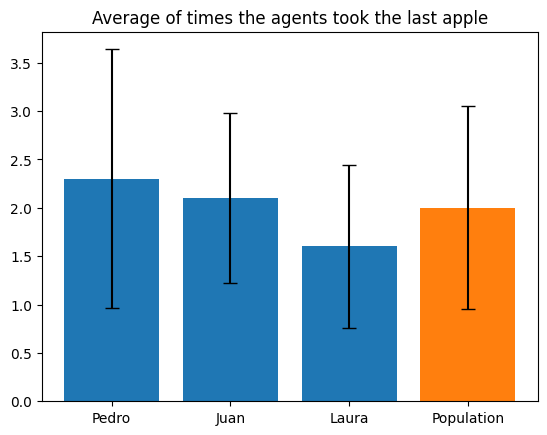

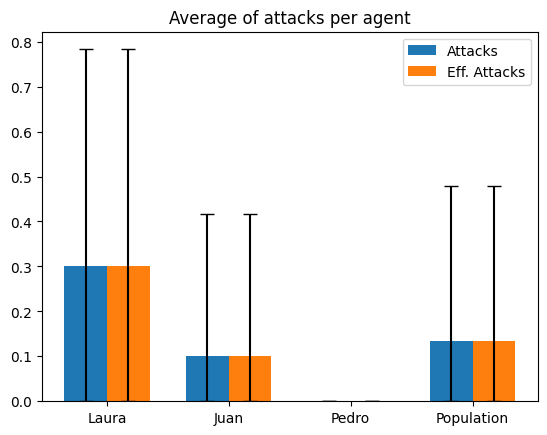

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\


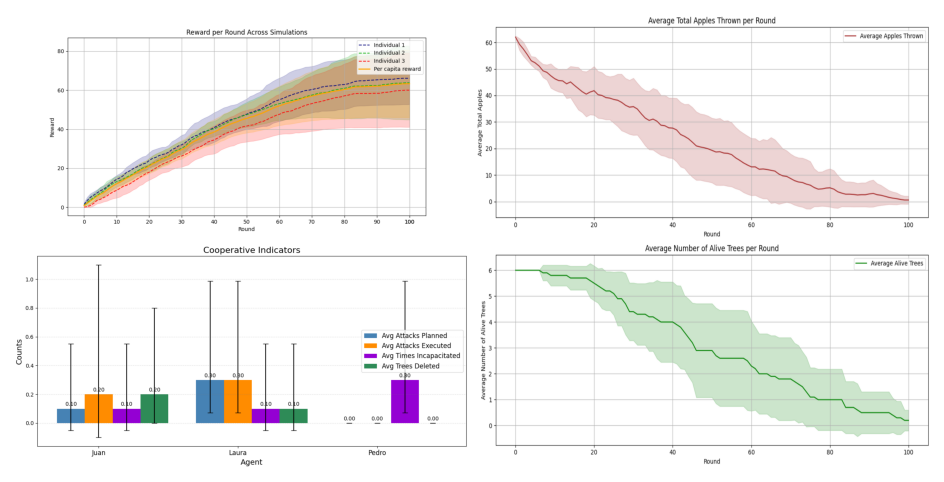

In [42]:
resilienece_path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/2_all_coop_with_definition'

recreate_rewards_records(resilienece_path)
recreate_trees_records(resilienece_path)
generate_avg_sims_attacks_plots(resilienece_path)
calculate_custom_indicators (resilienece_path)

create_one_dashboard_image(resilienece_path, show_plot=True)

### All Selfish With Definition

simulations_folder 2024-03-08--10-22-00__sim_8 cost: 8,65 duration: 416,91
simulations_folder 2024-03-08--10-21-54__sim_7 cost: 10,31 duration: 443,12
simulations_folder 2024-03-08--10-21-29__sim_2 cost: 10,32 duration: 443,53
simulations_folder 2024-03-08--10-22-05__sim_9 cost: 10,74 duration: 442,94
simulations_folder 2024-03-08--10-21-50__sim_6 cost: 10,60 duration: 443,22
simulations_folder 2024-03-08--10-21-24__sim_1 cost: 9,71 duration: 433,43
simulations_folder 2024-03-08--10-22-14__sim_10 cost: 10,69 duration: 442,75
simulations_folder 2024-03-08--10-21-34__sim_3 cost: 10,07 duration: 443,44
simulations_folder 2024-03-08--10-21-40__sim_4 cost: 10,86 duration: 443,36
simulations_folder 2024-03-08--10-21-45__sim_5 cost: 5,33 duration: 222,25
Sim 0 {'Juan': {'Laura': 0, 'Pedro': 1}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 1}, 'Laura': {'Juan': 1, 'Pedro': 1}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura':

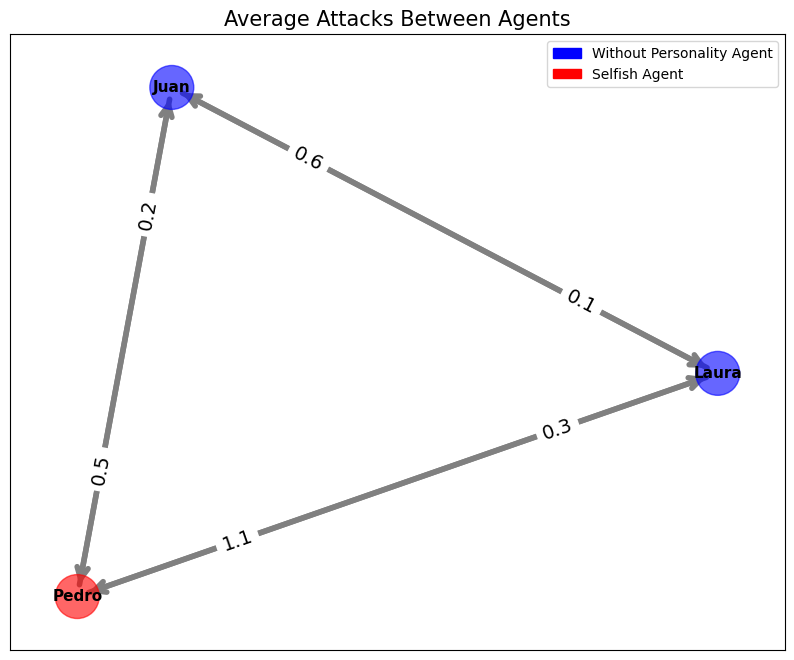

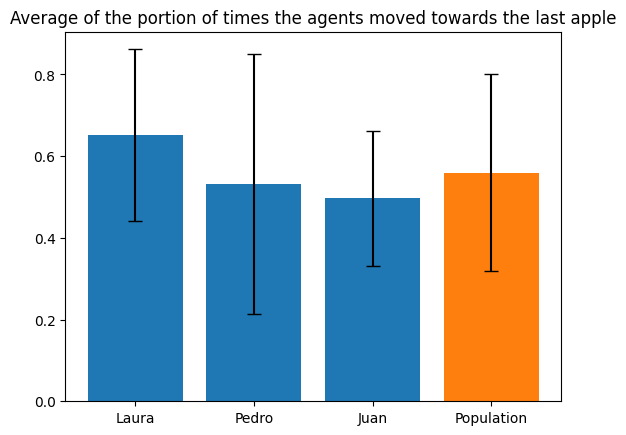

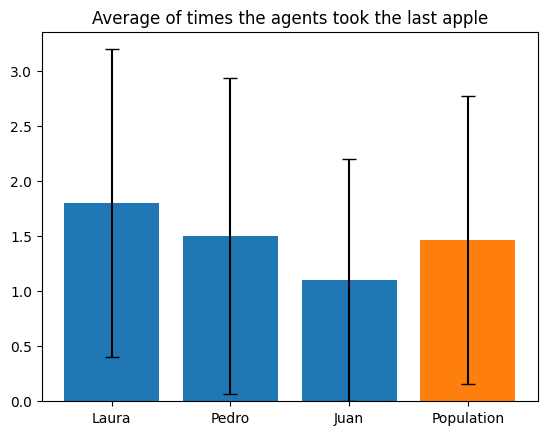

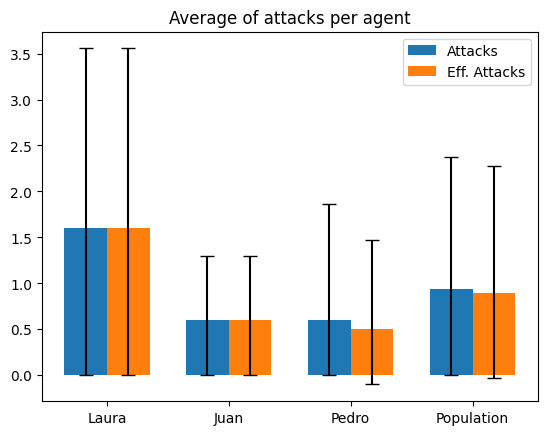

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\


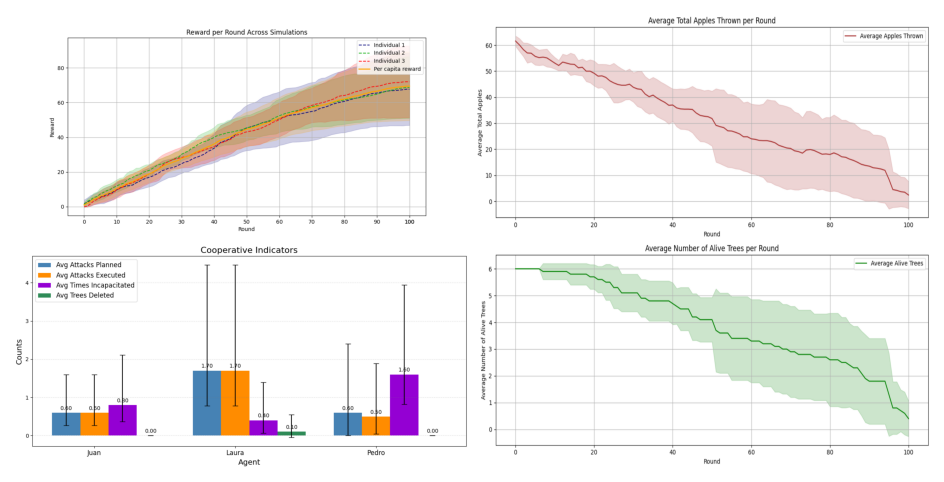

In [43]:
resilienece_path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/4_all_selfish_with_definition'

recreate_rewards_records(resilienece_path)
recreate_trees_records(resilienece_path)
generate_avg_sims_attacks_plots(resilienece_path)
calculate_custom_indicators (resilienece_path)

create_one_dashboard_image(resilienece_path, show_plot=True)

### One apple per tree

simulations_folder 2024-03-11--13-46-01__sim_8 cost: 1,58 duration: 27,26
simulations_folder 2024-03-11--13-45-37__sim_4 cost: 3,15 duration: 51,28
simulations_folder 2024-03-11--13-45-22__sim_1 cost: 3,29 duration: 56,06
simulations_folder 2024-03-11--13-45-42__sim_5 cost: 3,35 duration: 57,55
simulations_folder 2024-03-11--13-45-32__sim_3 cost: 3,17 duration: 53,34
simulations_folder 2024-03-11--13-46-04__sim_9 cost: 3,78 duration: 63,52
simulations_folder 2024-03-11--13-45-57__sim_7 cost: 3,33 duration: 57,01
simulations_folder 2024-03-11--13-46-09__sim_10 cost: 4,95 duration: 82,17
simulations_folder 2024-03-11--13-45-51__sim_6 cost: 3,88 duration: 63,53
simulations_folder 2024-03-11--13-45-27__sim_2 cost: 1,49 duration: 24,48
Sim 0 {'Juan': {'Laura': 1, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 3, 'Pedro': 1}, 'Pedro': {'Juan': 1, 'Laura': 0}}
Sim 2 {'Juan': {'Laura': 1, 'Pedro': 1}, 

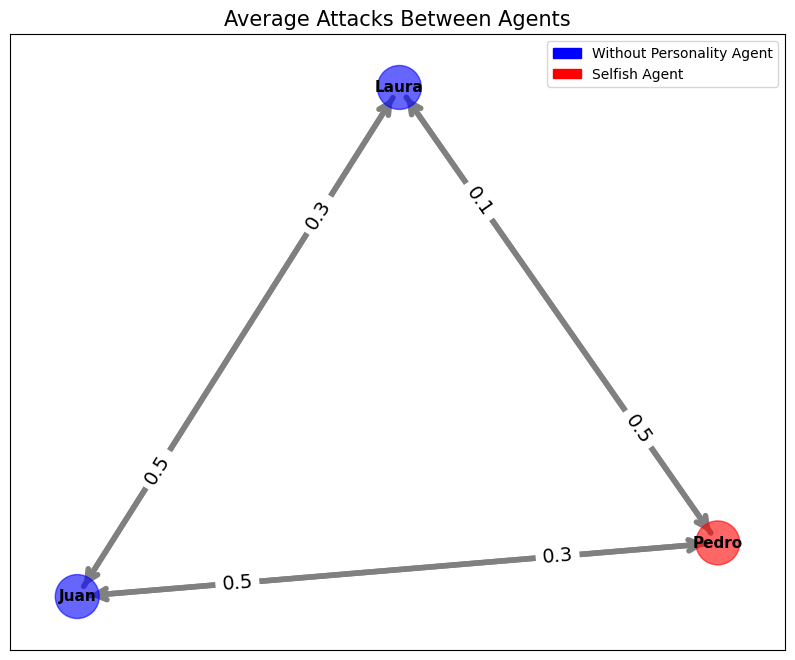

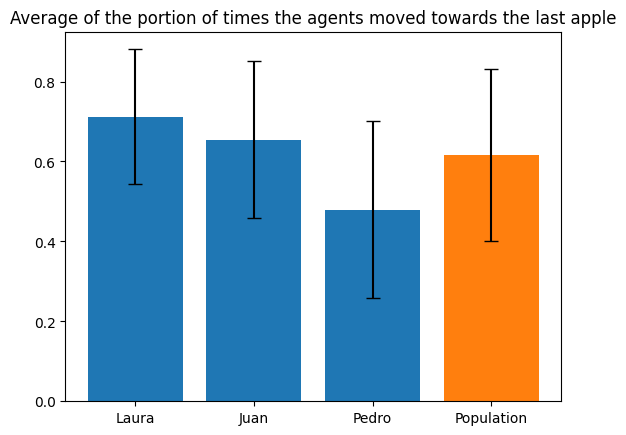

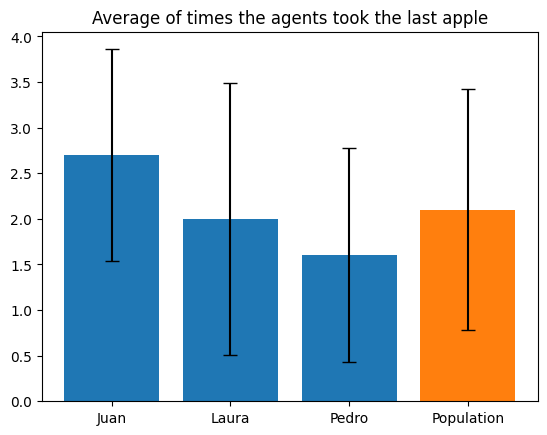

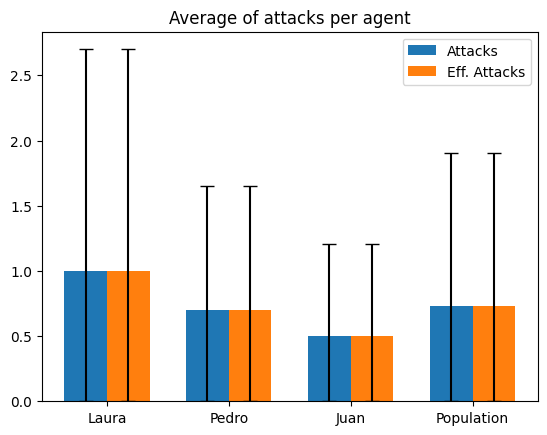

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\


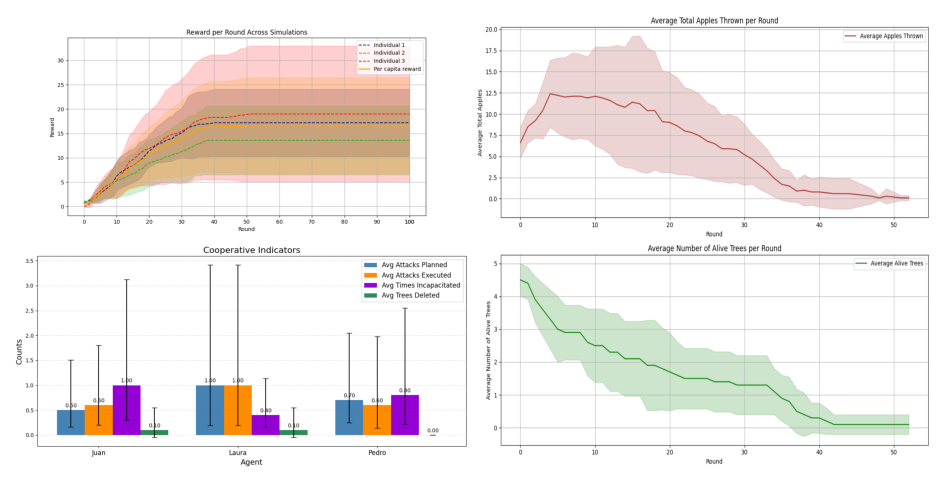

In [44]:
path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/6_one_apple_per_tree___no_bio'

recreate_rewards_records(path)
recreate_trees_records(path)
generate_avg_sims_attacks_plots(path)
calculate_custom_indicators (path)

create_one_dashboard_image(path, show_plot=True)

### One tree per map no bio

simulations_folder 2024-03-11--10-17-27__sim_8 cost: 0,60 duration: 12,30
simulations_folder 2024-03-11--10-17-37__sim_10 cost: 0,44 duration: 9,27
simulations_folder 2024-03-11--10-16-57__sim_2 cost: 0,61 duration: 11,73
simulations_folder 2024-03-11--10-17-22__sim_7 cost: 0,73 duration: 14,50
simulations_folder 2024-03-11--10-17-07__sim_4 cost: 1,16 duration: 33,44
simulations_folder 2024-03-11--10-17-11__sim_5 cost: 0,67 duration: 13,49
simulations_folder 2024-03-11--10-16-51__sim_1 cost: 1,18 duration: 22,58
simulations_folder 2024-03-11--10-17-01__sim_3 cost: 0,72 duration: 14,41
simulations_folder 2024-03-11--10-17-32__sim_9 cost: 0,48 duration: 11,34
simulations_folder 2024-03-11--10-17-16__sim_6 cost: 1,20 duration: 21,06
Sim 0 {'Juan': {'Laura': 0, 'Pedro': 1}, 'Laura': {'Juan': 1, 'Pedro': 0}, 'Pedro': {'Juan': 1, 'Laura': 0}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura': 0, 'Pedro': 0}, '

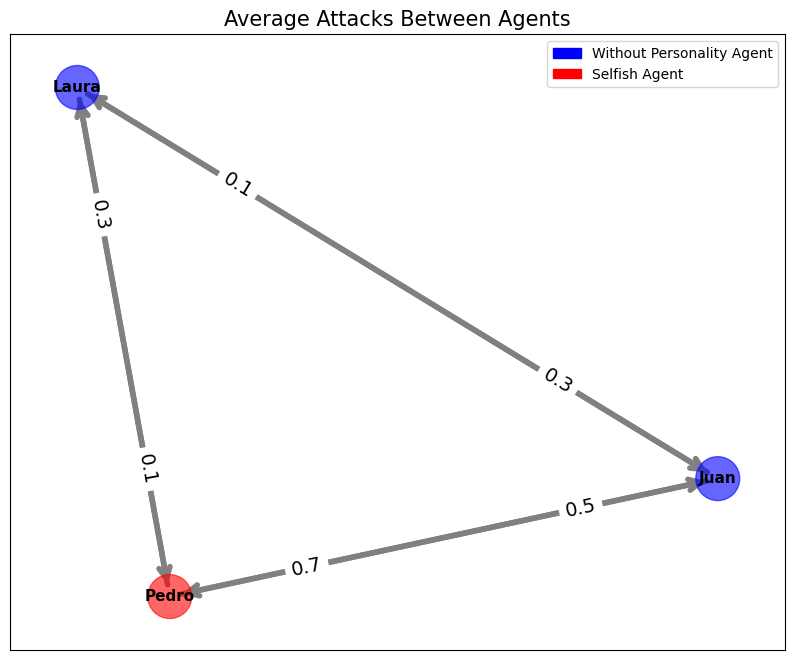

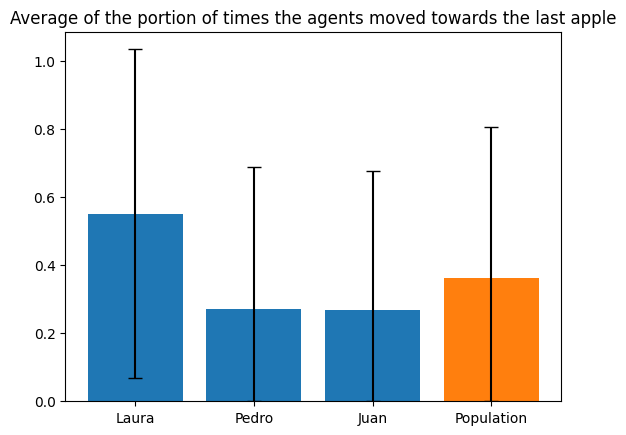

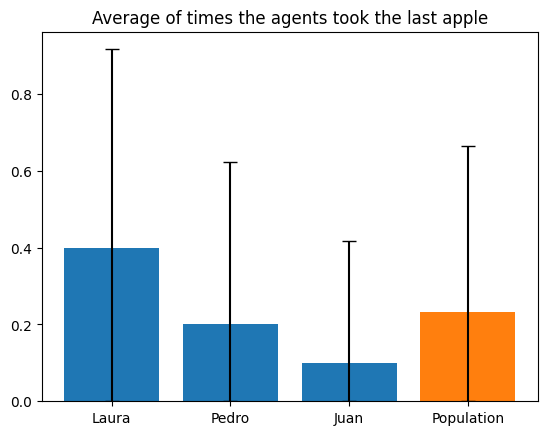

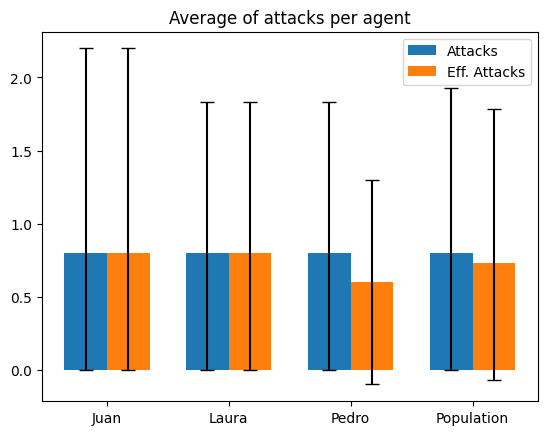

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\


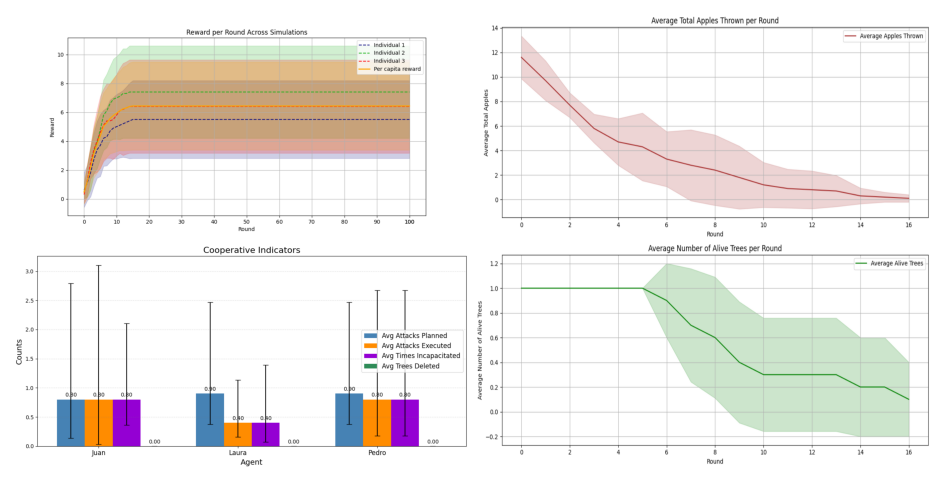

In [45]:
path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/8_one_tree_per_map___no_bio'

recreate_rewards_records(path)
recreate_trees_records(path)
generate_avg_sims_attacks_plots(path)
calculate_custom_indicators (path)

create_one_dashboard_image(path, show_plot=True)

### One tree per map all coop

simulations_folder 2024-03-12--22-25-11__sim_1 cost: 0,87 duration: 15,05
simulations_folder 2024-03-12--22-25-44__sim_8 cost: 0,71 duration: 12,49
simulations_folder 2024-03-12--22-25-18__sim_3 cost: 0,85 duration: 13,82
simulations_folder 2024-03-12--22-25-23__sim_4 cost: 1,16 duration: 20,63
simulations_folder 2024-03-12--22-25-54__sim_10 cost: 0,52 duration: 9,03
simulations_folder 2024-03-12--22-25-33__sim_6 cost: 0,71 duration: 11,84
simulations_folder 2024-03-12--22-25-28__sim_5 cost: 0,88 duration: 16,11
simulations_folder 2024-03-12--22-25-13__sim_2 cost: 0,62 duration: 13,13
simulations_folder 2024-03-12--22-25-38__sim_7 cost: 0,79 duration: 15,48
simulations_folder 2024-03-12--22-25-49__sim_9 cost: 0,70 duration: 11,67
Sim 0 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 1}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura': 0, 'Pedro': 0}, '

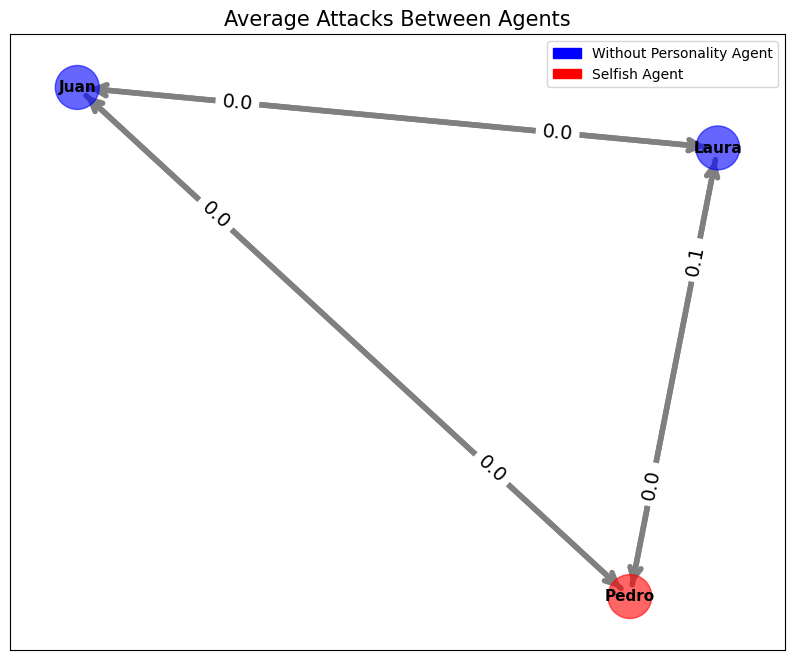

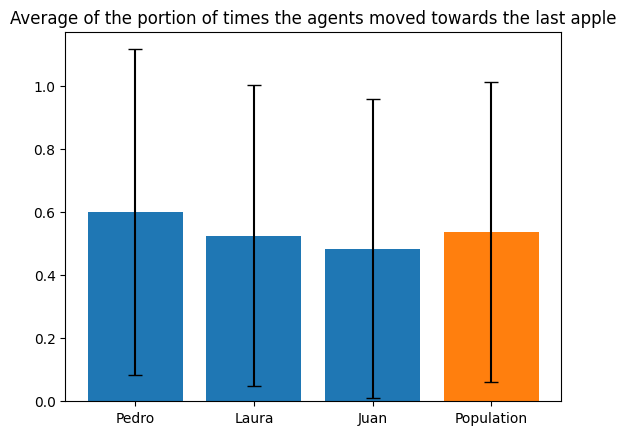

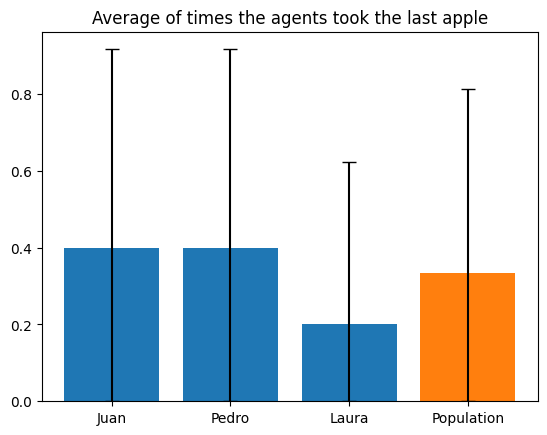

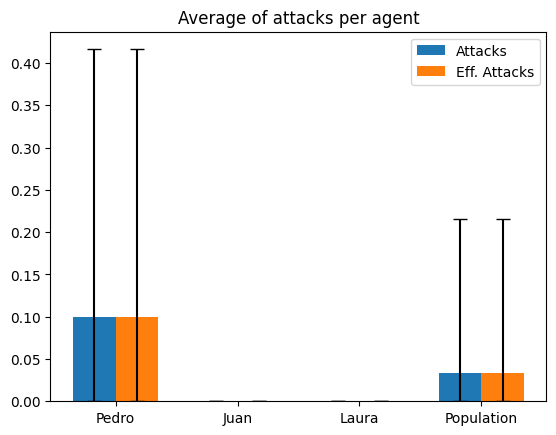

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\


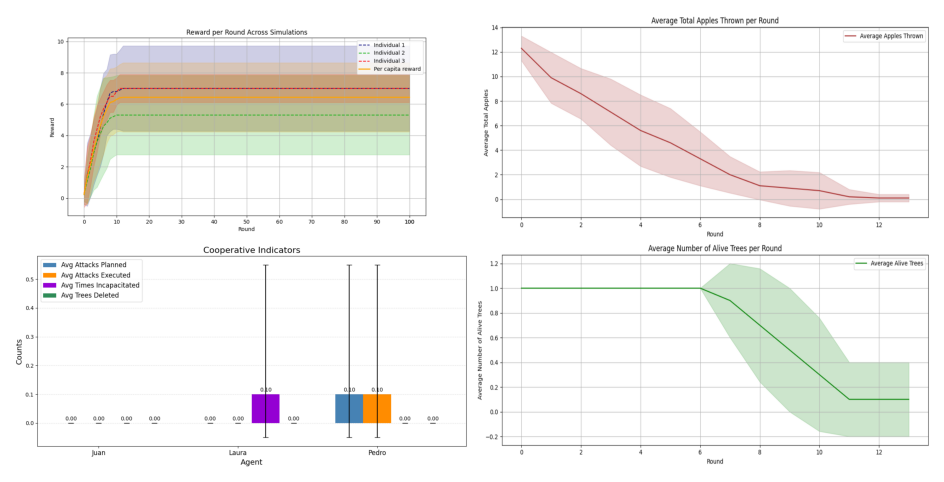

In [46]:
path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/9_one_tree_per_map___all_coop'

recreate_rewards_records(path)
recreate_trees_records(path)
generate_avg_sims_attacks_plots(path)
calculate_custom_indicators (path)

create_one_dashboard_image(path, show_plot=True)

### One tree per map all selfish

simulations_folder 2024-03-13--01-09-24__sim_8 cost: 1,55 duration: 24,41
simulations_folder 2024-03-13--01-09-05__sim_5 cost: 0,62 duration: 10,37
simulations_folder 2024-03-13--01-08-50__sim_2 cost: 0,91 duration: 16,22
simulations_folder 2024-03-13--01-09-10__sim_6 cost: 0,66 duration: 10,90
simulations_folder 2024-03-13--01-09-29__sim_9 cost: 1,22 duration: 18,46
simulations_folder 2024-03-13--01-09-15__sim_7 cost: 0,77 duration: 12,27
simulations_folder 2024-03-13--01-09-37__sim_10 cost: 0,63 duration: 10,95
simulations_folder 2024-03-13--01-08-55__sim_3 cost: 0,65 duration: 10,51
simulations_folder 2024-03-13--01-09-00__sim_4 cost: 0,68 duration: 11,65
simulations_folder 2024-03-13--01-08-49__sim_1 cost: 0,60 duration: 11,47
Sim 0 {'Juan': {'Laura': 0, 'Pedro': 2}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 1}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura': 0, 'Pedro': 0}, 

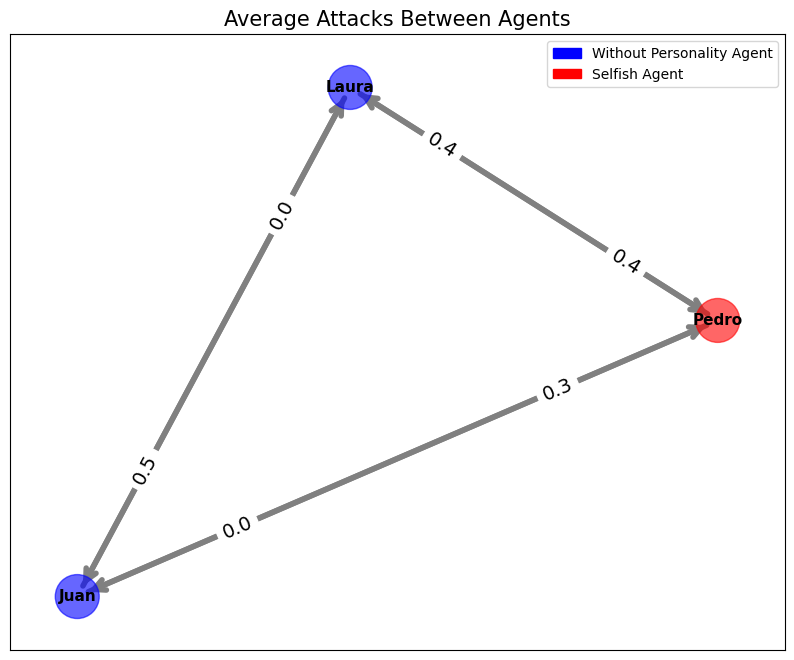

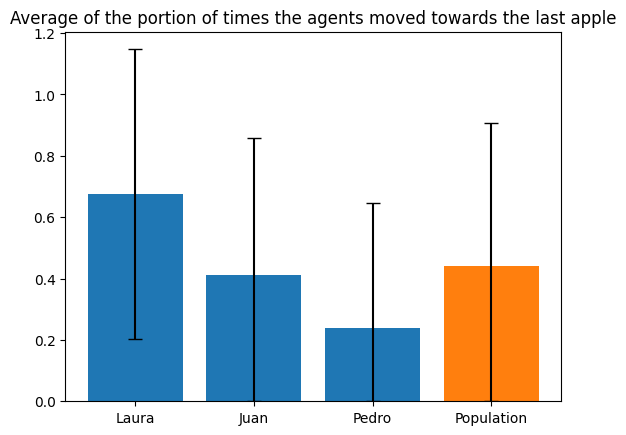

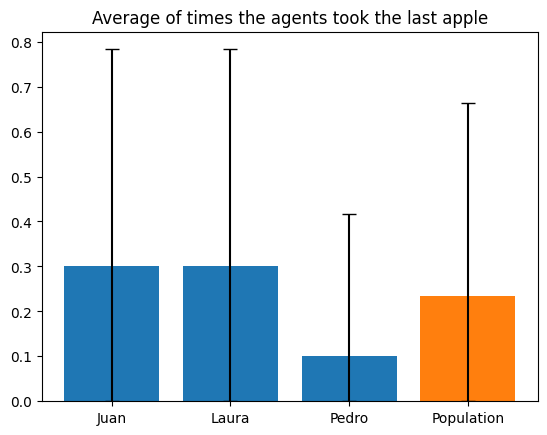

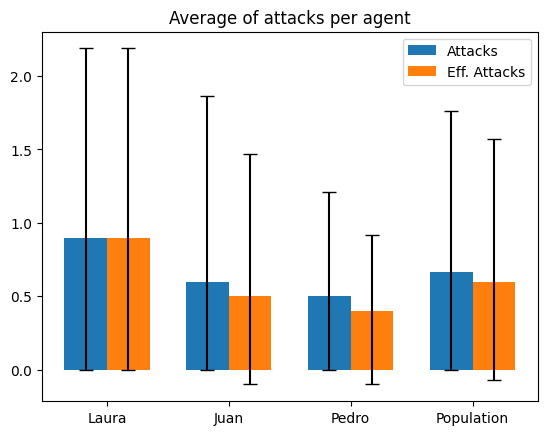

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\


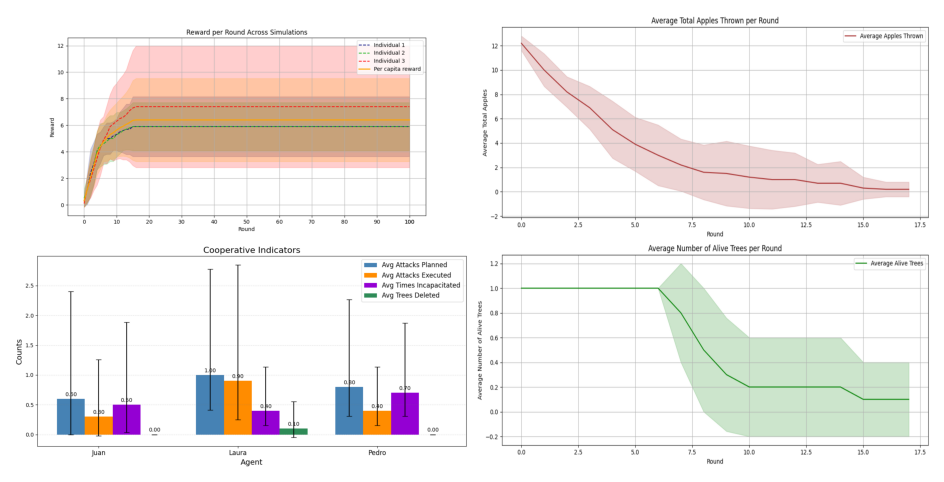

In [47]:
path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/10_one_tree_per_map___all_selfish'

recreate_rewards_records(path)
recreate_trees_records(path)
generate_avg_sims_attacks_plots(path)
calculate_custom_indicators (path)

create_one_dashboard_image(path, show_plot=True)

### x_pedro_is_selfish_with_definition

simulations_folder 2024-03-06--17-01-41__sim_2 cost: 10,77 duration: 161,00
simulations_folder 2024-03-06--17-01-52__sim_3 cost: 10,39 duration: 155,86
simulations_folder 2024-03-06--17-02-12__sim_7 cost: 10,13 duration: 155,57
simulations_folder 2024-03-06--17-02-06__sim_6 cost: 9,69 duration: 146,27
simulations_folder 2024-03-06--17-01-55__sim_4 cost: 10,38 duration: 155,82
simulations_folder 2024-03-06--17-02-15__sim_8 cost: 10,37 duration: 155,51
simulations_folder 2024-03-06--17-02-25__sim_10 cost: 7,52 duration: 121,92
simulations_folder 2024-03-06--17-02-19__sim_9 cost: 10,47 duration: 155,46
simulations_folder 2024-03-06--17-01-40__sim_1 cost: 10,49 duration: 156,05
simulations_folder 2024-03-06--17-01-59__sim_5 cost: 10,29 duration: 155,79
Sim 0 {'Juan': {'Laura': 1, 'Pedro': 6}, 'Laura': {'Juan': 1, 'Pedro': 4}, 'Pedro': {'Juan': 1, 'Laura': 0}}
Sim 1 {'Juan': {'Laura': 1, 'Pedro': 3}, 'Laura': {'Juan': 0, 'Pedro': 8}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura'

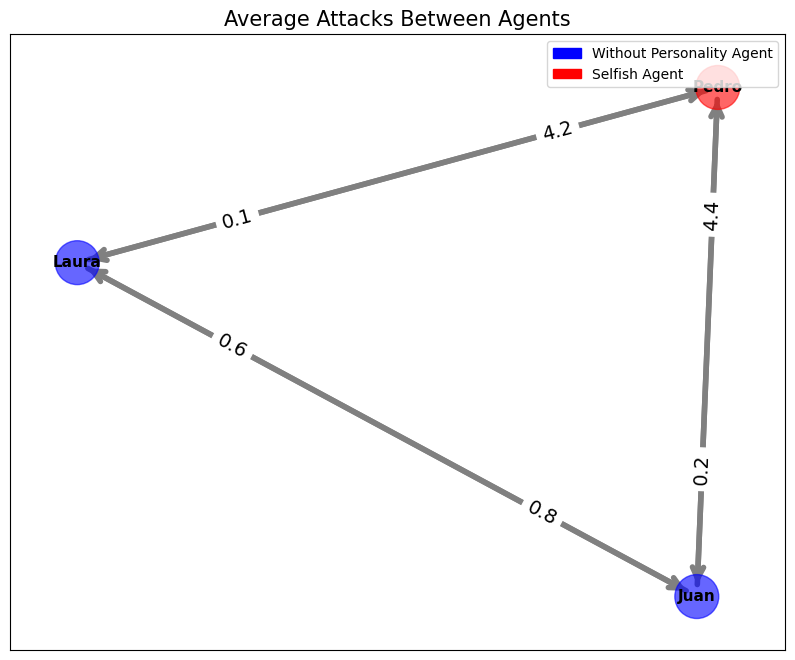

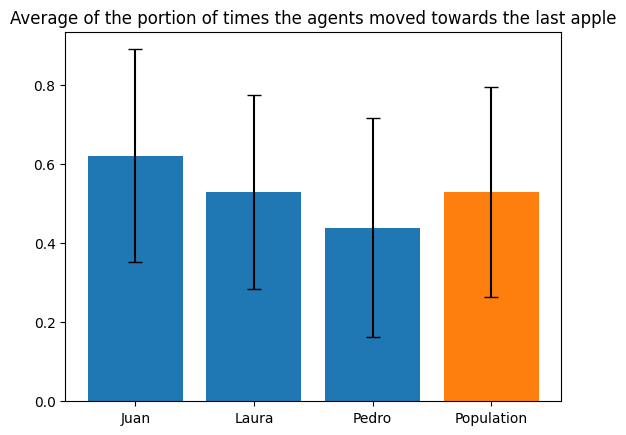

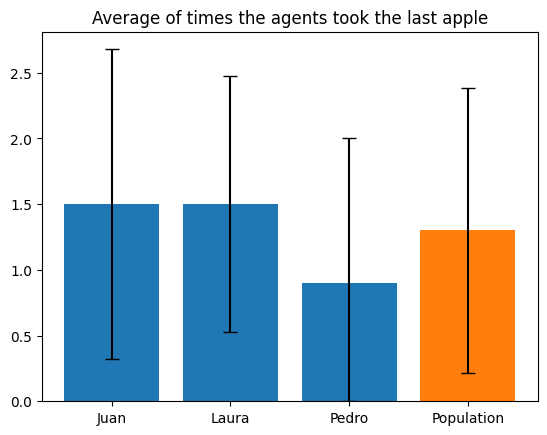

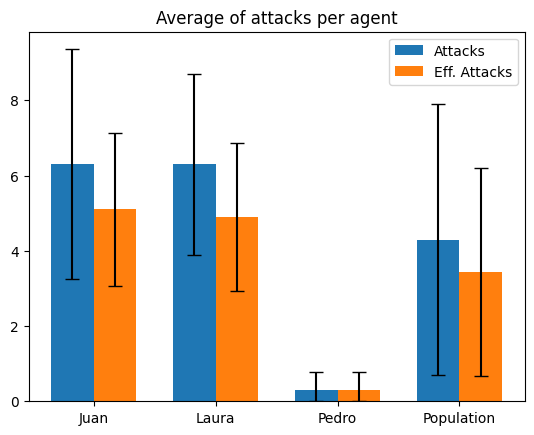

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\


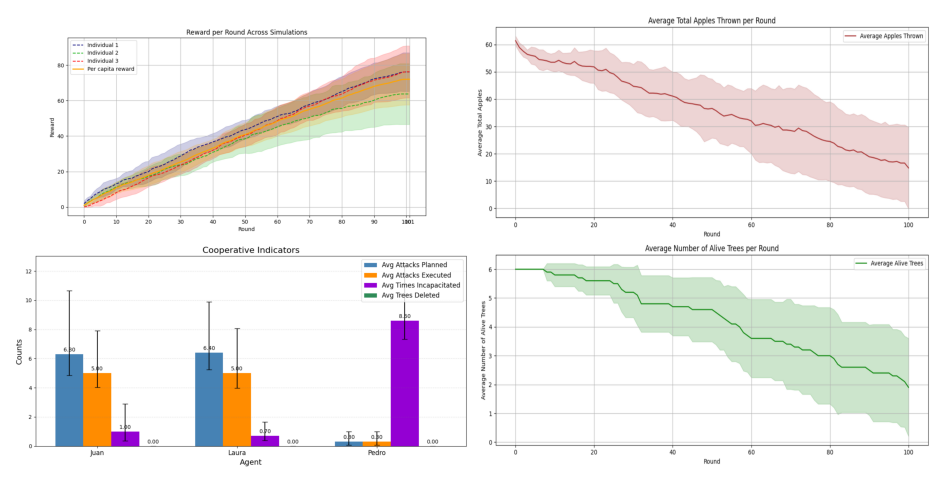

In [48]:
path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/x_pedro_is_selfish_with_definition'

recreate_rewards_records(path)
recreate_trees_records(path)
generate_avg_sims_attacks_plots(path)
calculate_custom_indicators (path)

create_one_dashboard_image(path, show_plot=True)


### One tree bots

simulations_folder 2024-03-13--13-45-39__sim_1 cost: 0,69 duration: 14,37
simulations_folder 2024-03-13--13-35-49__sim_7 cost: 0,20 duration: 4,85
simulations_folder 2024-03-13--13-45-56__sim_5 cost: 0,30 duration: 6,44
simulations_folder 2024-03-13--13-36-03__sim_8 cost: 0,23 duration: 5,47
simulations_folder 2024-03-13--13-35-20__sim_2 cost: 0,28 duration: 6,95
simulations_folder 2024-03-13--13-45-50__sim_4 cost: 0,27 duration: 5,53
simulations_folder 2024-03-13--13-46-01__sim_6 cost: 0,21 duration: 4,47
simulations_folder 2024-03-13--13-45-46__sim_3 cost: 0,26 duration: 5,28
simulations_folder 2024-03-13--13-45-40__sim_2 cost: 0,26 duration: 5,20
Sim 0 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 1 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 2 {'Juan': {'Laura': 0, 'Pedro': 0}, 'Laura': {'Juan': 0, 'Pedro': 0}, 'Pedro': {'Juan': 0, 'Laura': 0}}
Sim 3 {'Juan': 

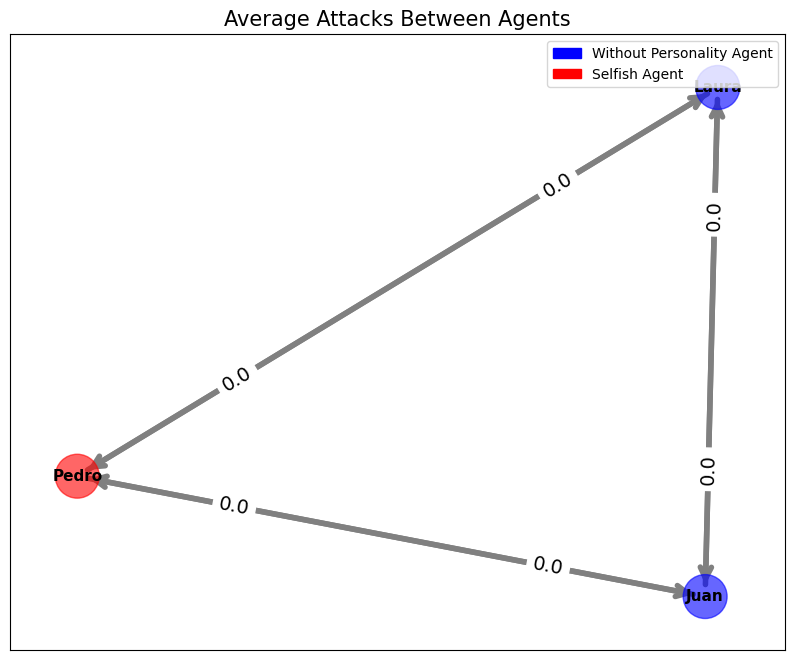

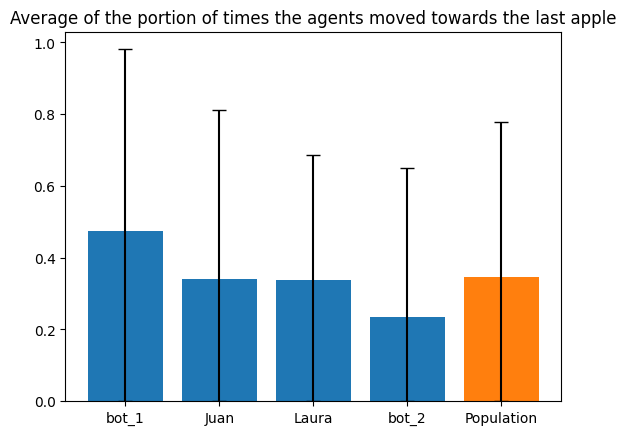

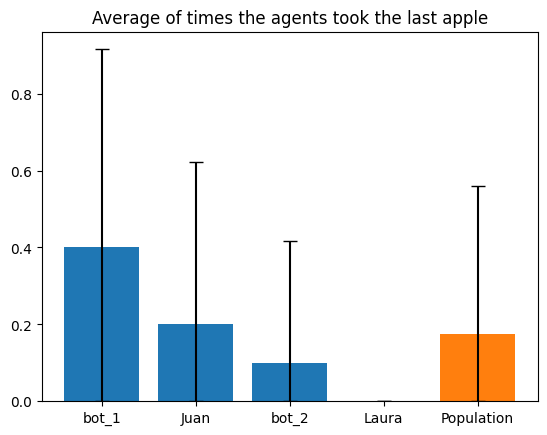

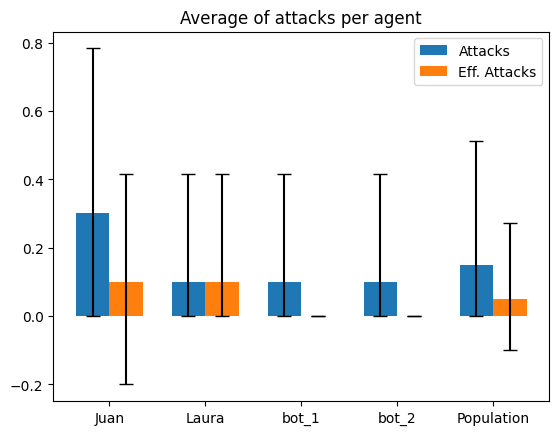

/tmp/ipykernel_1342644/2099761355.py:90: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pd.merge(df_by_agent, df_by_indicator, on=['indicator', 'agent', ('value', 'mean'), ('value', 'std')], how='outer').\
[ WARN:0@525.111] global loadsave.cpp:248 findDecoder imread_('/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/11_one_tree_per_map___bots/avg_rewards_plot.png'): can't open/read file: check file path/integrity
[ WARN:0@525.113] global loadsave.cpp:248 findDecoder imread_('/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/11_one_tree_per_map___bots/trees_and_apples_plot.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [49]:
path = '/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments/11_one_tree_per_map___bots'

#recreate_rewards_records(path)
#recreate_trees_records(path)
generate_avg_sims_attacks_plots(path)
calculate_custom_indicators (path)

create_one_dashboard_image(path, show_plot=True)

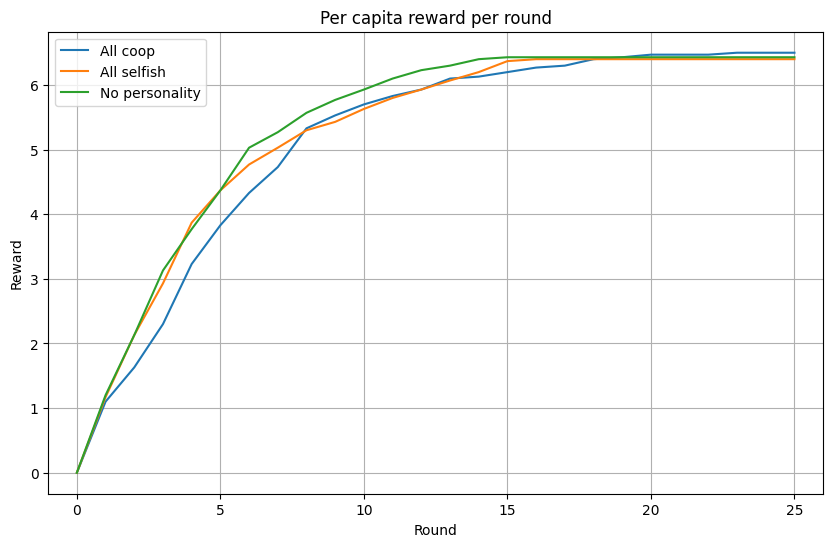

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def read_simulation_data(folder_path):
    """
    Lee los datos de simulación de un archivo CSV específico dentro de una carpeta.
    
    Args:
    - folder_path: La ruta al folder que contiene el archivo CSV.
    
    Returns:
    - Un DataFrame de pandas con los datos del archivo CSV.
    """
    csv_file_path = os.path.join(folder_path, "avg_rewards_plot.csv")
    return pd.read_csv(csv_file_path)

def plot_per_capita_reward(folders, legends, round_max_limit, simulations_folder):
    """
    Grafica el Reward Per Capita por ronda para múltiples simulaciones.
    
    Args:
    - folders: Lista de rutas a los folders que contienen los datos de las simulaciones.
    - legends: Lista de leyendas para la gráfica, correspondiente a cada simulación.
    - round_max_limit: Límite máximo para el eje x (rondas).
    """
    plt.figure(figsize=(10, 6))
    
    for folder, legend in zip(folders, legends):
        df = read_simulation_data(folder)
        # Change "Per capita reward" for round 0 to 0
        df.loc[df["round"] == 0, "Per capita reward"] = 0
        df = df.sort_values(by="round")
        # Take the values of the df that are less than the round_max_limit
        df = df[df["round"] <= round_max_limit]
        
        plt.plot(df["round"], df["Per capita reward"], label=legend)
    
    plt.title("Per capita reward per round")
    plt.xlabel("Round")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    
    if round_max_limit is not None:
        plt.xlim(-1, round_max_limit+1)
    #Add a pad to the left and right of the plot
    plt.margins(x=0.5)
    
    plt.savefig(simulations_folder+"/per_capita_reward.png")
    plt.show()

# Configuración de las rutas a los folders de simulación
simulations_folder = "/home/jeyseb/MP/CooperativeGPT/logs/_official_experiments"
folders = [
    f"{simulations_folder}/9_one_tree_per_map___all_coop_v2",
    f"{simulations_folder}/10_one_tree_per_map___all_selfish",
    f"{simulations_folder}/8_one_tree_per_map___no_bio"
]

# Leyendas para la gráfica
legends = ["All coop", "All selfish", "No personality"]

# Llamar a la función con un límite de ronda máximo
plot_per_capita_reward(folders, legends, round_max_limit=25, simulations_folder = simulations_folder)


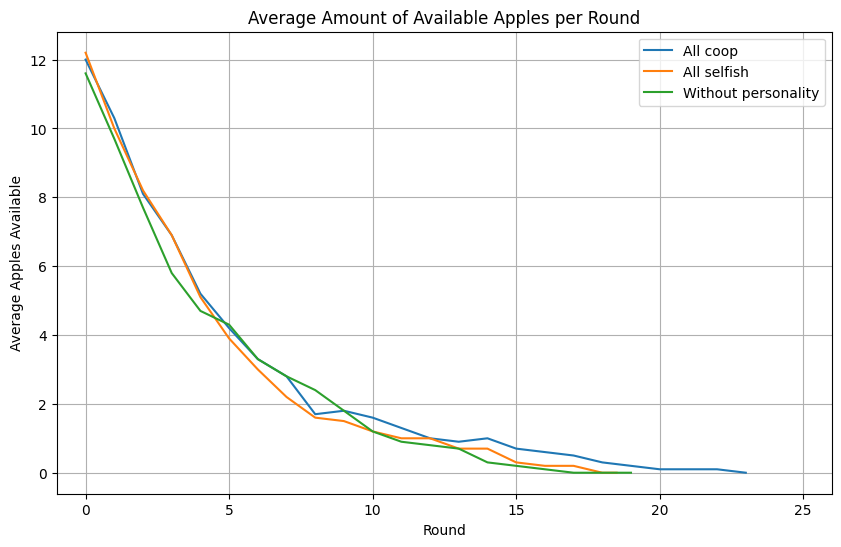

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def read_simulation_data(folder_path, file_name):
    """
    Reads simulation data from a specific CSV file within a folder.
    
    Args:
    - folder_path: Path to the folder containing the CSV file.
    - file_name: Name of the CSV file to be read.
    
    Returns:
    - A pandas DataFrame with the data from the CSV file.
    """
    csv_file_path = os.path.join(folder_path, file_name)
    return pd.read_csv(csv_file_path)

def plot_apple_availability(folders, legends, round_max_limit, simulations_folder):
    """
    Plots the Average Amount of Available Apples per round for multiple simulations.
    
    Args:
    - folders: List of paths to the folders containing the simulation data.
    - legends: List of legends for the graph, corresponding to each simulation.
    - round_max_limit: Maximum limit for the x-axis (rounds).
    - simulations_folder: Path to the main simulations folder for saving the plot.
    """
    plt.figure(figsize=(10, 6))
    
    for folder, legend in zip(folders, legends):
        df = read_simulation_data(folder, "trees_and_apples_plot.csv")
        # Adjust for round 0 if necessary and sort by round
        df = df.sort_values(by="round")
        # Take the values of the df that are less than or equal to round_max_limit
        df = df[df["round"] <= round_max_limit]
        
        plt.plot(df["round"], df["avg_trees_apples"], label=legend)
    
    plt.title("Average Amount of Available Apples per Round")
    plt.xlabel("Round")
    plt.ylabel("Average Apples Available")
    plt.legend()
    plt.grid(True)
    
    if round_max_limit is not None:
        plt.xlim(-1, round_max_limit + 1)
    # Add a margin to the left and right of the plot
    plt.margins(x=0.5)
    
    plt.savefig(os.path.join(simulations_folder, "apple_availability.png"))
    plt.show()

# Paths to the simulation folders are already configured
# You might need to adjust the paths or folder names based on your structure

# Call the function with a max round limit
plot_apple_availability(folders, legends, round_max_limit=25, simulations_folder=simulations_folder)


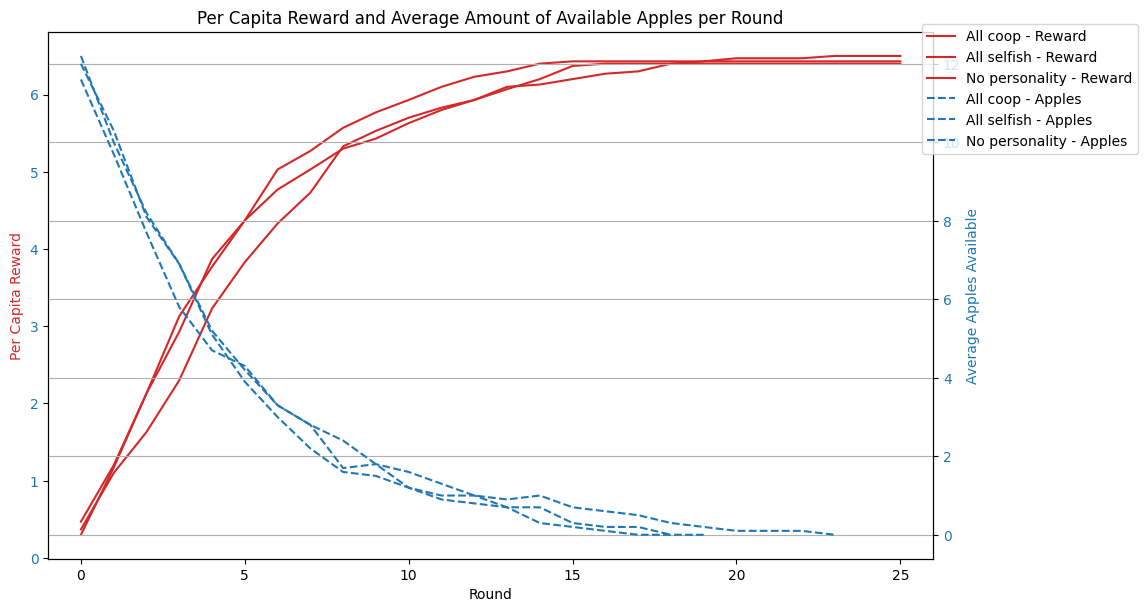

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def read_simulation_data(folder_path, file_name):
    """
    Reads simulation data from a specific CSV file within a folder.
    
    Args:
    - folder_path: Path to the folder containing the CSV file.
    - file_name: Name of the CSV file to be read.
    
    Returns:
    - A pandas DataFrame with the data from the CSV file.
    """
    csv_file_path = os.path.join(folder_path, file_name)
    return pd.read_csv(csv_file_path)

def plot_combined_metrics(folders, legends, round_max_limit, simulations_folder):
    """
    Plots both Per Capita Reward and Average Amount of Available Apples on the same graph with dual y-axes.
    
    Args:
    - folders: List of paths to the folders containing the simulation data.
    - legends: List of legends for the graph, corresponding to each simulation.
    - round_max_limit: Maximum limit for the x-axis (rounds).
    - simulations_folder: Path to the main simulations folder for saving the plot.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:red'
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Per Capita Reward', color=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Average Apples Available', color=color)  # we already handled the x-label with ax1
    
    for folder, legend in zip(folders, legends):
        df_reward = read_simulation_data(folder, "avg_rewards_plot.csv")
        df_apples = read_simulation_data(folder, "trees_and_apples_plot.csv")
        
        # Sorting and limiting rounds
        df_reward = df_reward.sort_values(by="round")[df_reward["round"] <= round_max_limit]
        df_apples = df_apples.sort_values(by="round")[df_apples["round"] <= round_max_limit]
        
        ax1.plot(df_reward["round"], df_reward["Per capita reward"], label=f"{legend} - Reward", color='tab:red')
        ax2.plot(df_apples["round"], df_apples["avg_trees_apples"], label=f"{legend} - Apples", color='tab:blue', linestyle='--')
    
    ax1.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("Per Capita Reward and Average Amount of Available Apples per Round")
    fig.legend(loc="upper right", bbox_to_anchor=(1.15,1))
    plt.grid(True)
    plt.xlim(-1, round_max_limit + 1)
    plt.margins(x=0.5)
    
    plt.savefig(os.path.join(simulations_folder, "combined_metrics.png"))
    plt.show()

# Las rutas a los folders de simulación y demás variables ya están configuradas
# Ahora solo necesitas llamar a la función modificada
plot_combined_metrics(folders, legends, round_max_limit=25, simulations_folder=simulations_folder)


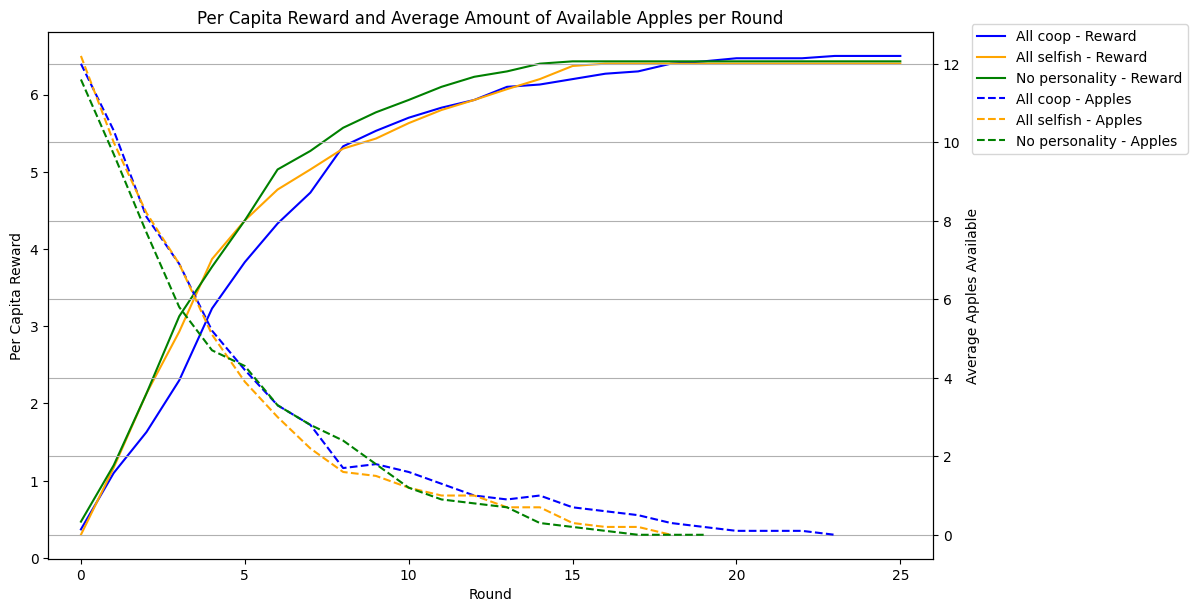

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def read_simulation_data(folder_path, file_name):
    """
    Reads simulation data from a specific CSV file within a folder.
    
    Args:
    - folder_path: Path to the folder containing the CSV file.
    - file_name: Name of the CSV file to be read.
    
    Returns:
    - A pandas DataFrame with the data from the CSV file.
    """
    csv_file_path = os.path.join(folder_path, file_name)
    return pd.read_csv(csv_file_path)

def plot_combined_metrics(folders, legends, round_max_limit, simulations_folder):
    """
    Plots both Per Capita Reward and Average Amount of Available Apples on the same graph with dual y-axes,
    using distinct colors for each simulation.
    
    Args:
    - folders: List of paths to the folders containing the simulation data.
    - legends: List of legends for the graph, corresponding to each simulation.
    - round_max_limit: Maximum limit for the x-axis (rounds).
    - simulations_folder: Path to the main simulations folder for saving the plot.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Per Capita Reward', color='black')  # Use black for better clarity
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel('Average Apples Available', color='black')  # Use black for better clarity
    
    colors = ['blue', 'orange', 'green']  # Extend this list if more than 3 simulations
    for (folder, legend, color) in zip(folders, legends, colors):
        df_reward = read_simulation_data(folder, "avg_rewards_plot.csv")
        df_apples = read_simulation_data(folder, "trees_and_apples_plot.csv")
        
        # Sorting and limiting rounds
        df_reward = df_reward.sort_values(by="round")[df_reward["round"] <= round_max_limit]
        df_apples = df_apples.sort_values(by="round")[df_apples["round"] <= round_max_limit]
        
        ax1.plot(df_reward["round"], df_reward["Per capita reward"], label=f"{legend} - Reward", color=color)
        ax2.plot(df_apples["round"], df_apples["avg_trees_apples"], label=f"{legend} - Apples", color=color, linestyle='--')
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("Per Capita Reward and Average Amount of Available Apples per Round")
    fig.legend(loc="upper right", bbox_to_anchor=(1.2,1))
    plt.grid(True)
    plt.xlim(-1, round_max_limit + 1)
    plt.margins(x=0)
    
    plt.savefig(os.path.join(simulations_folder, "combined_metrics.png"))
    plt.show()

plot_combined_metrics(folders, legends, round_max_limit=25, simulations_folder=simulations_folder)
